In [62]:
import pandas as pd
import pymysql
import numpy as np
import requests
from datetime import datetime, timedelta

# CoinMarketCap.com API Key
api_key = "a86e3326-8c8d-434e-897a-5d6becbf1f35"
top_symbols_count = 1500
required_tags = ['binance-smart-chain','polkadot-ecosystem','ethereum','cosmos-ecosystem','polkadot','solana-ecosystem','binance-chain','avalanche-ecosystem','heco','layer-2','eos','sidechain','cosmos','tron','defi','yield-farming','decentralized-exchange','governance','dao','gaming','stablecoin','asset-management','centralized-exchange','staking','yield-aggregator','oracles','lending-borowing','dex','options','launchpad','stablecoin-algorithmically-stabilized']


In [63]:
def __connect__():
    db_user = 'coin'
    db_password = 'dragonstone#123'
    db_name = 'master_data'
    db_host = 'localhost'
    return pymysql.connect(
        unix_socket=None,
        host=db_host,
        user=db_user,
        password=db_password,
        db=db_name,
        charset='latin1',
        cursorclass=pymysql.cursors.DictCursor)


def get_cursor(connection):
    if connection is None:
        connection = __connect__()
    connection.ping(reconnect=True)
    return connection.cursor()

### Today's Top Defi Coins (marcketCap) under 1100

In [64]:


def fetch_top_n_market_cap_symbols_(n):
    url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
    payload = {
        'convert':'USD',
        'aux':'cmc_rank',
        'limit':n,
#         'tag':'defi'
    }
    headers = {
      'Accepts': 'application/json',
      'X-CMC_PRO_API_KEY': api_key
    }
    data = requests.get(url, params=payload, headers=headers).json()['data']
    return data

def parse_data(rows):
    parsed_data = []
    for data in rows:
        if data['cmc_rank'] < top_symbols_count:
            parsed_data.append([data['name'], data['symbol'],data['cmc_rank'], data['quote']['USD']['market_cap']])
    return parsed_data


def get_top_symbols():
    data = fetch_top_n_market_cap_symbols_(top_symbols_count)
    d = parse_data(data)
    sybmol_rank_df = pd.DataFrame(d, columns = ['name','symbol', 'rank', 'market_cap'])
    top_symbols = sybmol_rank_df['symbol'].values.tolist()
    return top_symbols

In [65]:
top_symbols = get_top_symbols()

In [66]:
top_symbols

['BTC',
 'ETH',
 'USDT',
 'BNB',
 'ADA',
 'XRP',
 'DOGE',
 'DOT',
 'USDC',
 'ICP',
 'UNI',
 'BCH',
 'MATIC',
 'LINK',
 'LTC',
 'XLM',
 'ETC',
 'SOL',
 'BUSD',
 'VET',
 'THETA',
 'WBTC',
 'EOS',
 'TRX',
 'FIL',
 'AAVE',
 'XMR',
 'DAI',
 'NEO',
 'KLAY',
 'SHIB',
 'MKR',
 'FTT',
 'BSV',
 'CRO',
 'XTZ',
 'MIOTA',
 'CAKE',
 'ATOM',
 'ALGO',
 'LUNA',
 'HT',
 'BTT',
 'KSM',
 'RUNE',
 'AVAX',
 'COMP',
 'HBAR',
 'DASH',
 'BTCB',
 'LEO',
 'EGLD',
 'UST',
 'TEL',
 'HOT',
 'DCR',
 'ZEC',
 'YFI',
 'XEM',
 'WAVES',
 'CEL',
 'SNX',
 'SUSHI',
 'CHZ',
 'TFUEL',
 'REV',
 'ZIL',
 'MANA',
 'PAX',
 'NEAR',
 'HNT',
 'QTUM',
 'BAT',
 'NEXO',
 'STX',
 'BTG',
 'ENJ',
 'ZEN',
 'TUSD',
 'ONE',
 'NANO',
 'DGB',
 'GRT',
 'ONT',
 'OMG',
 'BNT',
 'CHSB',
 'FTM',
 'SC',
 'HUSD',
 'ZRX',
 'UMA',
 'OKB',
 'RVN',
 'CELO',
 'MDX',
 'ANKR',
 'BAKE',
 'ICX',
 'XDC',
 'FLOW',
 'CRV',
 'BCD',
 'KCS',
 'VGX',
 'LSK',
 'LPT',
 'IOST',
 'AR',
 '1INCH',
 'RSR',
 'LRC',
 'QNT',
 'REN',
 'XVG',
 'WRX',
 'RLC',
 'DENT',
 'RENBTC',


In [67]:
def get_defi_tvl_data_df():
    defi_tvl = pd.read_sql_query("select * from notebook_defi_tvl;", __connect__())
    defi_tvl = defi_tvl.sort_values(['date', 'Symbol', 'Name'])
    defi_tvl['date'] = pd.to_datetime(defi_tvl['date'].dt.strftime('%Y-%m-%d'), format='%Y-%m-%d')
    defi_tvl = defi_tvl.groupby(['date', 'Symbol', 'Name']).tail(1)
    defi_tvl = defi_tvl.reset_index(drop=True)
    return defi_tvl
    

In [68]:
def get_supply_data_df():
    cmc_supply = pd.read_sql_query("select * from notebook_cmc_supply;", __connect__())
    cgck_supply = pd.read_sql_query("select * from notebook_coingecko_supply;", __connect__())
    cgck_min_date = cgck_supply.date.min()
    cmc_supply = cmc_supply[cmc_supply['date'] < cgck_min_date]
    cmc_supply = cmc_supply[cmc_supply['Symbol'].isin(cgck_supply.Symbol.values.tolist())]
    master_df = cmc_supply.append(cgck_supply)
    return master_df

In [69]:
def get_joins_data_df():
    master_symbols = pd.read_sql_query("select symbol as Symbol, current_name as Name, group_concat(tags, ',') as Tags from cmc_coin_metainfo group by symbol, current_name;", __connect__())
    cmc_supply = get_supply_data_df()
    db_tvl = pd.read_sql_query("select * from notebook_debank_data;", __connect__())
    defi_tvl = get_defi_tvl_data_df()
    dune_tua = pd.read_sql_query("select * from notebook_dune_tua;", __connect__())
    tt_metrics = pd.read_sql_query("select * from notebook_tt_metric_v2;", __connect__())
    defistation_tvl = pd.read_sql_query("select * from notebook_defisation_tvl;", __connect__())
    solana_tvl = pd.read_sql_query("select * from notebook_solana_tvl;", __connect__())
    master_df = pd.merge(cmc_supply, db_tvl, how='left', left_on=['date', 'Symbol', 'Name'], right_on=['date', 'Symbol', 'Name'])
    master_df = pd.merge(master_df, defi_tvl, how='left', left_on=['date', 'Symbol', 'Name'], right_on=['date', 'Symbol', 'Name'])
    master_df = pd.merge(master_df, dune_tua, how='left', left_on=['date', 'Symbol', 'Name'], right_on=['date', 'Symbol', 'Name'])
    master_df = pd.merge(master_df, tt_metrics, how='left', left_on=['date', 'Symbol', 'Name'], right_on=['date', 'Symbol', 'Name'])
    master_df = pd.merge(master_df, defistation_tvl, how='left', left_on=['date', 'Symbol', 'Name'], right_on=['date', 'Symbol', 'Name'])
    master_df = pd.merge(master_df, solana_tvl, how='left', left_on=['date', 'Symbol', 'Name'], right_on=['date', 'Symbol', 'Name'])
    master_df = pd.merge(master_df, master_symbols, left_on=['Symbol', 'Name'], right_on=['Symbol', 'Name'])
    master_df['required'] = (master_df['is_defistation'] == 1) | (master_df['is_solana'] == 1) | (master_df['is_debank'] == 1) | (master_df['is_tt_coin'] == 1) | (master_df['is_defi_tvl'] == 1) | (master_df['is_dune_tua'] == 1)
    del master_df['is_debank']
    del master_df['is_tt_coin']
    del master_df['is_defi_tvl']
    del master_df['is_dune_tua']
    del master_df['is_cmc_supply']
    del master_df['is_defistation']
    del master_df['is_solana']
    return master_df

In [70]:
def get_data_df(top_symbols):
    df = get_joins_data_df()
    df = df[(df['Symbol'].isin(top_symbols)) | (df['required'])]
    df = df.reset_index(drop=True)
    return df

In [71]:
df = get_data_df(top_symbols)

In [72]:
df.columns

Index(['date', 'Symbol', 'Name', 'Price', 'Marketcap CMC', 'Volume CMC',
       'Circulating supply CMC', 'MAX Supply CMC', 'Total Supply CMC',
       'Users 24hr Debank', 'Transactions Count Debank',
       'Trading Volume Debank', 'Borrowing Volume Debank', 'TVL Debank',
       'TVL Defipulse', 'Users life-to-date duneanlytics', 'Revenue TT',
       'Revenue Supply Side TT', 'Revenue Protocol TT', 'Price/Sale', 'GMV TT',
       'tvl_defistation', 'users_defistation', 'tvl_solana', 'Tags',
       'required'],
      dtype='object')

In [73]:
print(df.date.max())
print(df.date.min())

2021-05-25 00:00:00
2020-12-21 00:00:00


In [74]:
original_df = df.copy()

In [76]:
df.columns

Index(['date', 'Symbol', 'Name', 'Price', 'Marketcap CMC', 'Volume CMC',
       'Circulating supply CMC', 'MAX Supply CMC', 'Total Supply CMC',
       'Users 24hr Debank', 'Transactions Count Debank',
       'Trading Volume Debank', 'Borrowing Volume Debank', 'TVL Debank',
       'TVL Defipulse', 'Users life-to-date duneanlytics', 'Revenue TT',
       'Revenue Supply Side TT', 'Revenue Protocol TT', 'Price/Sale', 'GMV TT',
       'tvl_defistation', 'users_defistation', 'tvl_solana', 'Tags',
       'required'],
      dtype='object')

In [77]:
ffill_columns = ['Users life-to-date duneanlytics', 'tvl_defistation', 'tvl_solana', 'tvl_defistation', 'Revenue TT', 'Revenue Supply Side TT', 'Revenue Protocol TT', 'Price/Sale', 'GMV TT']

def ffill_columns_values(df, columns):
    df = df.reset_index(drop=True)
    df.index = pd.DatetimeIndex(df['date'])
    for column in columns:
        df[column] = df.groupby(['Symbol','Name'])[column].ffill()
    df = df.reset_index(drop=True)
    return df

In [78]:
df = ffill_columns_values(df, ffill_columns)

In [79]:
df[df['Symbol'] == 'RAY']['tvl_solana']

123705             NaN
123706             NaN
123707             NaN
123708             NaN
123709             NaN
              ...     
123794    5.891269e+08
123795    4.895894e+08
123796    4.335738e+08
123797    3.816011e+08
123798    4.111275e+08
Name: tvl_solana, Length: 94, dtype: float64

In [80]:
df['tvl_solana'].unique()

array([           nan, 0.00000000e+00, 4.45861062e+08, 4.45076346e+08,
       4.45519149e+08, 4.44905498e+08, 4.45356058e+08, 4.45759883e+08,
       6.33835211e+08, 3.71837282e+08, 3.83344711e+08, 3.30601584e+08,
       2.82004268e+08, 7.19633295e+08, 1.63888194e+08, 2.71702243e+08,
       2.75747185e+08, 2.58113176e+08, 9.69052755e+08, 9.09568917e+08,
       8.92364010e+08, 8.71818935e+08, 8.84248455e+08, 8.96846414e+08,
       9.03882875e+08, 8.22191598e+08, 8.40023216e+08, 7.59183463e+08,
       5.72324893e+08, 5.89126899e+08, 4.89589431e+08, 4.33573815e+08,
       3.81601083e+08, 4.11127539e+08, 8.14700855e+06, 7.85549573e+06,
       7.89382394e+06, 7.78710145e+06, 7.94200262e+06, 8.10388656e+06,
       8.19222803e+06, 7.52205293e+06, 7.50050631e+06, 6.86164234e+06,
       6.40619884e+06, 6.32692777e+06, 5.80969140e+06, 5.71489607e+06,
       5.75503959e+06, 6.01787080e+06])

In [81]:
df.tvl_defistation.unique()

array([           nan, 4.62461020e+07, 4.88026000e+07, 4.90605420e+07,
       4.90642220e+07, 4.96506560e+07, 5.36302300e+07, 5.75815550e+07,
       4.49131250e+07, 4.50991780e+07, 5.21909290e+07, 5.24390620e+07,
       5.78788300e+07, 5.43695920e+07, 5.60008900e+07, 5.83077400e+07,
       5.40171460e+07, 5.41363560e+07, 4.60445350e+07, 5.11838440e+07,
       4.86117730e+07, 6.19581300e+07, 3.46272893e+08, 3.10564992e+08,
       2.85999315e+08, 2.58151838e+08, 2.66240335e+08, 2.68665567e+08,
       2.75638314e+08, 2.78215781e+08, 2.88140036e+08, 3.06567058e+08,
       2.94280322e+08, 3.17491919e+08, 3.06983806e+08, 3.00181712e+08,
       3.09579903e+08, 3.16033468e+08, 3.29972260e+08, 3.36647940e+08,
       3.38425668e+08, 3.42402466e+08, 3.57669801e+08, 3.38850364e+08,
       3.39613206e+08, 3.36880991e+08, 3.37185417e+08, 3.20546324e+08,
       3.14923994e+08, 2.57915860e+08, 2.29008084e+08, 2.18047083e+08,
       1.94155865e+08, 1.80091775e+08, 1.73178828e+08, 1.84439405e+08,
      

### Adding cmc tags as column

In [82]:
def append_tags_in_columns(df):
    required_tags.sort()
    tag_df = pd.DataFrame(df['Tags'].copy())

    required_tags_map = {}
    i = 0
    for tag in required_tags:
        required_tags_map[tag] = i
        i = i + 1

    all_symbol_tags = []
    for index, row in tag_df.iterrows():
        tag = [''] * (len(required_tags))
        tags = row['Tags']
        tags = tags.split(',') if tags else []
        for t in tags:
            index = required_tags_map[t] if t in required_tags_map else -1
            if index > -1:
                tag[index] = 1
        all_symbol_tags.append(tag)

    tag_columns = []
    tag_columns.extend(required_tags)

    tag_column_df = pd.DataFrame(all_symbol_tags, columns = tag_columns)
    df = df.join(tag_column_df)
    del df['Tags']
    df.reset_index(inplace=True, drop=True)
    return df

In [83]:
df = append_tags_in_columns(df)

Filter symbols.

In [84]:
exceptional_coins = ['BTC', 'ETH', 'BNB', 'SOL']
df = df[(df['Symbol'].isin(exceptional_coins)) | (df['defi'] == 1) | (df['required'])]
del df['required']
# df = df[(df['defi'] == 1)]



In [85]:
len(df.Symbol.unique())

242

In [86]:
df[df['Symbol'] == 'BNB']

,date,Symbol,Name,Price,Marketcap CMC,Volume CMC,Circulating supply CMC,MAX Supply CMC,Total Supply CMC,Users 24hr Debank,...,polkadot,polkadot-ecosystem,sidechain,solana-ecosystem,stablecoin,stablecoin-algorithmically-stabilized,staking,tron,yield-aggregator,yield-farming
5576,2020-12-21,BNB,Binance Coin,32.269528,4.659932e+09,5.830005e+08,144406560.9,176406561.0,176406560.9,NaN,...,,,,,,,,,,
5577,2020-12-22,BNB,Binance Coin,33.482948,4.835157e+09,5.639255e+08,144406560.9,176406561.0,176406560.9,NaN,...,,,,,,,,,,
5578,2020-12-23,BNB,Binance Coin,31.097899,4.490741e+09,5.826138e+08,144406560.9,176406561.0,176406560.9,NaN,...,,,,,,,,,,
5579,2020-12-24,BNB,Binance Coin,32.500593,4.693299e+09,4.882635e+08,144406560.9,176406561.0,176406560.9,NaN,...,,,,,,,,,,
5580,2020-12-25,BNB,Binance Coin,33.164974,4.789240e+09,4.210265e+08,144406560.9,176406561.0,176406560.9,NaN,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5727,2021-05-21,BNB,Binance Coin,326.296320,5.006459e+10,6.291182e+09,153432897.0,170532785.0,169432897.0,NaN,...,,,,,,,,,,
5728,2021-05-22,BNB,Binance Coin,299.504094,4.595378e+10,3.871243e+09,153432897.0,170532785.0,169432897.0,NaN,...,,,,,,,,,,
5729,2021-05-23,BNB,Binance Coin,260.450000,4.024847e+10,3.945099e+09,154533651.9,170533651.9,170533651.9,NaN,...,,,,,,,,,,
5730,2021-05-24,BNB,Binance Coin,290.140000,4.494614e+10,7.044846e+09,154533651.9,170533651.9,170533651.9,NaN,...,,,,,,,,,,


### adding columns like TVL_max, Defi Volume_max, users_life_max and etc.

In [89]:
def add_other_columns(df):
#     df['TVL_max'] = df[['TVL Debank', 'TVL Defipulse']].max(axis=1)
#     df['TVL_max'] = df[['TVL Debank', 'TVL Defipulse', 'tvl_defistation']].max(axis=1)
    df['emission_rate'] = df['Circulating supply CMC'].pct_change
    df['TVL_max'] = df[['TVL Debank', 'TVL Defipulse', 'tvl_defistation', 'tvl_solana']].max(axis=1)
    df['GMV'] = df['GMV TT']
    df['Defi Volume DeBank'] = (df['Trading Volume Debank'].fillna(0) + df['Borrowing Volume Debank'].fillna(0)).replace({'0':np.nan, 0:np.nan})
    # add defi volume max as max of gmv from tokenterminal and defi volume debank
    df['Defi Volume_max'] = df[['GMV', 'Defi Volume DeBank']].max(axis=1)
    # add defi volume max as max of gmv from tokenterminal and defi volume debank
    df['Defi Volume_max'] = df[['GMV', 'Defi Volume DeBank']].max(axis=1)
    df['max_test'] = df[['MAX Supply CMC', 'Total Supply CMC']].max(axis=1)
    df['fully_diluted_mkt_cap'] = df.max_test * df.Price
    df["total_revenue"] = df['Revenue TT']
    df["total_supply_revenue"] = df['Revenue Supply Side TT']
    df["total_protocol_revenue"] = df['Revenue Protocol TT']
    df['users_life_max'] = df[['users_defistation', 'Users life-to-date duneanlytics']].max(axis=1)
    del df['max_test']
    df = df.sort_values('date')
    return df

In [90]:
df = add_other_columns(df)

In [91]:
def select_required_metrics_coins_only(df):

    def fillter_coins_basis_metrics(df, column, symbol):
        tmp_df = df[df['Symbol'] == symbol][column].isnull()
        return tmp_df.sum() == tmp_df.count()

    to_delete_symbols = []
    required_metrics = ['TVL_max', 'Defi Volume_max', 'total_revenue']
    symbols = df.Symbol.unique().tolist()
    for symbol in symbols:
        to_delete = True
        for metric in required_metrics:
            to_delete = fillter_coins_basis_metrics(df, metric, symbol)
            if not to_delete:
                break
        to_delete_symbols.append([symbol, to_delete])
    to_delete_symbols_df = pd.DataFrame(to_delete_symbols, columns=['Symbol', 'to_delete'])
    to_delete_symbols_df = to_delete_symbols_df[to_delete_symbols_df['to_delete']]
    to_delete_symbols = to_delete_symbols_df['Symbol'].values.tolist()
    df2 = df.drop(df[df['Symbol'].isin(to_delete_symbols)].index)
    df2 = df2.reset_index(drop=True)
    return df2

In [92]:
df = select_required_metrics_coins_only(df)
df

,date,Symbol,Name,Price,Marketcap CMC,Volume CMC,Circulating supply CMC,MAX Supply CMC,Total Supply CMC,Users 24hr Debank,...,yield-farming,TVL_max,GMV,Defi Volume DeBank,Defi Volume_max,fully_diluted_mkt_cap,total_revenue,total_supply_revenue,total_protocol_revenue,users_life_max
0,2020-12-21,DEGO,Dego Finance,0.644889,0.000000e+00,3.800104e+05,0.000000e+00,NaN,8.777127e+06,NaN,...,,3.654700e+06,NaN,NaN,NaN,5.660276e+06,NaN,NaN,NaN,NaN
1,2020-12-21,FRM,Ferrum Network,0.102912,1.485981e+07,1.093253e+06,1.443936e+08,3.317188e+08,3.292187e+08,NaN,...,,3.643854e+06,NaN,NaN,NaN,3.413779e+07,NaN,NaN,NaN,NaN
2,2020-12-21,AAVE,Aave,81.311937,9.757233e+08,2.154891e+08,1.199975e+07,1.600000e+07,1.600000e+07,NaN,...,1,1.794887e+09,3.279500e+08,4.197027e+08,4.197027e+08,1.300991e+09,48690.184183,48114.20227,575.981913,32549.0
3,2020-12-21,UMA,UMA,9.354550,5.192399e+08,5.155217e+07,5.550667e+07,NaN,1.011313e+08,NaN,...,,4.864894e+07,NaN,NaN,NaN,9.460378e+08,NaN,NaN,NaN,NaN
4,2020-12-21,ORAI,Oraichain Token,13.084811,5.019046e+06,1.347903e+06,3.835780e+05,8.600000e+07,8.600000e+07,NaN,...,,3.251086e+06,NaN,NaN,NaN,1.125294e+09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17595,2021-05-25,LINA,Linear,0.048003,1.188892e+08,3.037170e+07,2.476691e+09,1.000000e+10,1.000000e+10,NaN,...,1,7.429588e+07,NaN,NaN,NaN,4.800324e+08,NaN,NaN,NaN,11592.0
17596,2021-05-25,BOND,BarnBridge,28.620000,7.271831e+07,2.145087e+06,2.551087e+06,1.000000e+07,1.000000e+07,NaN,...,1,8.172971e+07,NaN,NaN,NaN,2.862000e+08,NaN,NaN,NaN,NaN
17597,2021-05-25,NUTS,Squirrel Finance,3.240000,3.121345e+06,3.931090e+05,9.635000e+05,NaN,NaN,NaN,...,,1.158797e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2688.0
17598,2021-05-25,OXY,Oxygen,2.170000,4.398917e+08,2.802513e+06,2.023615e+08,1.000000e+10,1.000000e+10,NaN,...,1,6.017871e+06,NaN,NaN,NaN,2.170000e+10,NaN,NaN,NaN,NaN


In [93]:
def get_symbol_name_pairs(df):
    cmc_symbol_name_df = df[['Symbol', 'Name']].drop_duplicates().reset_index(drop=True)
    return cmc_symbol_name_df


In [94]:
cmc_symbol_name_df = get_symbol_name_pairs(df)

In [96]:
cmc_symbol_name_df

,Symbol,Name
0,DEGO,Dego Finance
1,FRM,Ferrum Network
2,AAVE,Aave
3,UMA,UMA
4,ORAI,Oraichain Token
...,...,...
154,FUEL,Jetfuel Finance
155,COFI,CoFiX
156,ALCX,Alchemix
157,YELD,Yeld Finance


### Adding all ratios

In [97]:
# add n day users
def calculate_nDay_users(df, days):
    column_name = f"total_users_{days}d"
    df[column_name] = 0
    for index, row in cmc_symbol_name_df.iterrows():
        symbol = row['Symbol']
        name = row['Name']
        temp_df = df[(df['Symbol'] == symbol) & (df['Name'] == name)].copy()
        temp_df['parent_index'] = temp_df.index
        temp_df.index = pd.DatetimeIndex(temp_df['date'])
        temp_df[column_name] = temp_df['Users 24hr Debank'].rolling(f"{days}d").sum()
        temp_df.index = temp_df["parent_index"]
        del temp_df['parent_index']
        for index, row in temp_df.iterrows():
            df.loc[index, column_name] = row[column_name]

In [98]:
def calculate_nDay_revenue(df, days):
    column_name = f"total_revenue_{days}d"
    df[column_name] = 0
    for index, row in cmc_symbol_name_df.iterrows():
        symbol = row['Symbol']
        name = row['Name']
        temp_df = df[(df['Symbol'] == symbol) & (df['Name'] == name)].copy()
        temp_df['parent_index'] = temp_df.index
        temp_df.index = pd.DatetimeIndex(temp_df['date'])
        temp_df[column_name] = temp_df['total_revenue'].rolling(f"{days}d").sum()
        temp_df.index = temp_df["parent_index"]
        del temp_df['parent_index']
        for index, row in temp_df.iterrows():
            df.loc[index, column_name] = row[column_name]
    

In [99]:
# function for defi volume sums
# substitute for volume cmc sum
# changing defi volume debank to Defi Volume_max
def calculate_nDay_defi_volume(df, days):
    column_name = f"total_defi_volume_{days}d"
    df[column_name] = 0
    for index, row in cmc_symbol_name_df.iterrows():
        symbol = row['Symbol']
        name = row['Name']
        temp_df = df[(df['Symbol'] == symbol) & (df['Name'] == name)].copy()
        temp_df['parent_index'] = temp_df.index
        temp_df.index = pd.DatetimeIndex(temp_df['date'])
        temp_df[column_name] = temp_df['Defi Volume_max'].rolling(f"{days}d").sum()
        temp_df.index = temp_df["parent_index"]
        del temp_df['parent_index']
        for index, row in temp_df.iterrows():
            df.loc[index, column_name] = row[column_name]
            

In [100]:
def calculate_nDay_change(df, days, column, column_name):
    df[column_name] = 0
    for index, row in cmc_symbol_name_df.iterrows():
        symbol = row['Symbol']
        name = row['Name']
        temp_df = df[(df['Symbol'] == symbol) & (df['Name'] == name)].copy()
        temp_df['parent_index'] = temp_df.index
        temp_df.index = pd.DatetimeIndex(temp_df['date'])
        temp_df[column_name] = temp_df[column].pct_change(days)
        temp_df.index = temp_df["parent_index"]
        del temp_df['parent_index']
        for index, row in temp_df.iterrows():
            df.loc[index, column_name] = row[column_name]
    
def calculate_nDay_std(df, days, column, column_name, div_by_column='Price'):
    df[column_name] = 0
    for index, row in cmc_symbol_name_df.iterrows():
        symbol = row['Symbol']
        name = row['Name']
        temp_df = df[(df['Symbol'] == symbol) & (df['Name'] == name)].copy()
        temp_df['parent_index'] = temp_df.index
        temp_df.index = pd.DatetimeIndex(temp_df['date'])
        temp_df[column_name] = temp_df[column].rolling(days).std() / temp_df[div_by_column]
        temp_df.index = temp_df["parent_index"]
        del temp_df['parent_index']
        for index, row in temp_df.iterrows():
            df.loc[index, column_name] = row[column_name]
    

In [101]:
def add_ratios_and_pct_change(df):
    calculate_nDay_revenue(df, 7)
    calculate_nDay_revenue(df, 30)
    #calculate_nDay_trading_volume(df, 30)
    calculate_nDay_defi_volume(df, 30)

    # add n day users
    calculate_nDay_users(df, 30)

    # add 1, 3, 7, 30 day defi volume pct change here
    # added column calculations
    #
    calculate_nDay_change(df, 1, 'Defi Volume_max', 'Defi_volume_pct_chg_1d')
    calculate_nDay_change(df, 3, 'Defi Volume_max', 'Defi_volume_pct_chg_3d')
    calculate_nDay_change(df, 7, 'Defi Volume_max', 'Defi_volume_pct_chg_7d')
    calculate_nDay_change(df, 30, 'Defi Volume_max', 'Defi_volume_pct_chg_30d')
    #
    # flip such that mc in numerator 
    #df['VOL : MC'] = df['Volume CMC'] / df['Marketcap CMC']
    df['MC : VOL'] = df['Marketcap CMC'] / df['Volume CMC'] 
    # added column calculations
    calculate_nDay_change(df, 1, 'MC : VOL', 'MC_VOL_pct_chg_1d')
    calculate_nDay_change(df, 3, 'MC : VOL', 'MC_VOL_pct_chg_3d')
    calculate_nDay_change(df, 7, 'MC : VOL', 'MC_VOL_pct_chg_7d')
    calculate_nDay_change(df, 30, 'MC : VOL', 'MC_VOL_pct_chg_30d')
    #

    # flip such that mc in numerator
    #df['VOL : DMC'] = df['Volume CMC'] / df['fully_diluted_mkt_cap']
    df['DMC : VOL'] = df['fully_diluted_mkt_cap'] / df['Volume CMC']
    # added column calculations
    calculate_nDay_change(df, 1, 'DMC : VOL', 'DMC_VOL_pct_chg_1d')
    calculate_nDay_change(df, 3, 'DMC : VOL', 'DMC_VOL_pct_chg_3d')
    calculate_nDay_change(df, 7, 'DMC : VOL', 'DMC_VOL_pct_chg_7d')
    calculate_nDay_change(df, 30, 'DMC : VOL', 'DMC_VOL_pct_chg_30d')
    #



    df['MC : TVL'] = df['Marketcap CMC'] / df['TVL_max']
    # added column calculations
    calculate_nDay_change(df, 1, 'MC : TVL', 'MC_TVL_pct_chg_1d')
    calculate_nDay_change(df, 3, 'MC : TVL', 'MC_TVL_pct_chg_3d')
    calculate_nDay_change(df, 7, 'MC : TVL', 'MC_TVL_pct_chg_7d')
    calculate_nDay_change(df, 30, 'MC : TVL', 'MC_TVL_pct_chg_30d')
    #


    df['DMC : TVL'] = df['fully_diluted_mkt_cap'] / df['TVL_max']
    # added column calculations
    calculate_nDay_change(df, 1, 'DMC : TVL', 'DMC_TVL_pct_chg_1d')
    calculate_nDay_change(df, 3, 'DMC : TVL', 'DMC_TVL_pct_chg_3d')
    calculate_nDay_change(df, 7, 'DMC : TVL', 'DMC_TVL_pct_chg_7d')
    calculate_nDay_change(df, 30, 'DMC : TVL', 'DMC_TVL_pct_chg_30d')
    #


    df['MC : users (1d)'] = df['Marketcap CMC'] / df['Users 24hr Debank']
    # added column calculations
    calculate_nDay_change(df, 1, 'MC : users (1d)', 'MC_users_pct_chg_1d')
    calculate_nDay_change(df, 3, 'MC : users (1d)', 'MC_users_pct_chg_3d')
    calculate_nDay_change(df, 7, 'MC : users (1d)', 'MC_users_pct_chg_7d')
    calculate_nDay_change(df, 30, 'MC : users (1d)', 'MC_users_pct_chg_30d')
    #




    df['DMC : users (1d)'] = df['fully_diluted_mkt_cap'] / df['Users 24hr Debank']
    # added column calculations
    calculate_nDay_change(df, 1, 'DMC : users (1d)', 'DMC_users_pct_chg_1d')
    calculate_nDay_change(df, 3, 'DMC : users (1d)', 'DMC_users_pct_chg_3d')
    calculate_nDay_change(df, 7, 'DMC : users (1d)', 'DMC_users_pct_chg_7d')
    calculate_nDay_change(df, 30, 'DMC : users (1d)', 'DMC_users_pct_chg_30d')
    #



    df['MC : transactions (1d)'] = df['Marketcap CMC'] / df['Transactions Count Debank']
    # added column calculations
    calculate_nDay_change(df, 1, 'MC : transactions (1d)', 'MC_transactions_pct_chg_1d')
    calculate_nDay_change(df, 3, 'MC : transactions (1d)', 'MC_transactions_pct_chg_3d')
    calculate_nDay_change(df, 7, 'MC : transactions (1d)', 'MC_transactions_pct_chg_7d')
    calculate_nDay_change(df, 30, 'MC : transactions (1d)', 'MC_transactions_pct_chg_30d')
    #

    df['DMC : transactions (1d)'] = df['fully_diluted_mkt_cap'] / df['Transactions Count Debank']
    # added column calculations
    calculate_nDay_change(df, 1, 'DMC : transactions (1d)', 'DMC_transactions_pct_chg_1d')
    calculate_nDay_change(df, 3, 'DMC : transactions (1d)', 'DMC_transactions_pct_chg_3d')
    calculate_nDay_change(df, 7, 'DMC : transactions (1d)', 'DMC_transactions_pct_chg_7d')
    calculate_nDay_change(df, 30, 'DMC : transactions (1d)', 'DMC_transactions_pct_chg_30d')
    #

    #df['MC : DEX Vol (1d)'] = df['Marketcap CMC'] / df['Trading Volume Debank']
    # add
    df['MC : Defi Vol (1d)'] = df['Marketcap CMC'] / df['Defi Volume_max']
    # added column calculations
    calculate_nDay_change(df, 1, 'MC : Defi Vol (1d)', 'MC_defi_volume_pct_chg_1d')
    calculate_nDay_change(df, 3, 'MC : Defi Vol (1d)', 'MC_defi_volume_pct_chg_3d')
    calculate_nDay_change(df, 7, 'MC : Defi Vol (1d)', 'MC_defi_volume_pct_chg_7d')
    calculate_nDay_change(df, 30, 'MC : Defi Vol (1d)', 'MC_defi_volume_pct_chg_30d')
    #


    df['MC : Defi Vol (30d)'] = df['Marketcap CMC'] / df['total_defi_volume_30d']
    #df['DMC : DEX Vol (1d)'] = df['fully_diluted_mkt_cap'] / df['Trading Volume Debank']
    #df['DMC : DEX Vol (30d)'] = df['fully_diluted_mkt_cap'] / df['total_volume_30d']



    df['MC : revenue'] = df['Marketcap CMC'] / df['total_revenue']
    # added column calculations
    calculate_nDay_change(df, 1, 'MC : revenue', 'MC_revenue_pct_chg_1d')
    calculate_nDay_change(df, 3, 'MC : revenue', 'MC_revenue_pct_chg_3d')
    calculate_nDay_change(df, 7, 'MC : revenue', 'MC_revenue_pct_chg_7d')
    calculate_nDay_change(df, 30, 'MC : revenue', 'MC_revenue_pct_chg_30d')
    #

    df['DMC : revenue'] = df['fully_diluted_mkt_cap'] / df['total_revenue']
    # added column calculations
    calculate_nDay_change(df, 1, 'DMC : revenue', 'DMC_revenue_pct_chg_1d')
    calculate_nDay_change(df, 3, 'DMC : revenue', 'DMC_revenue_pct_chg_3d')
    calculate_nDay_change(df, 7, 'DMC : revenue', 'DMC_revenue_pct_chg_7d')
    calculate_nDay_change(df, 30, 'DMC : revenue', 'DMC_revenue_pct_chg_30d')
    #


    df['MC : total_users_30d'] = df['Marketcap CMC'] / df['total_users_30d']
    # added column calculations
    calculate_nDay_change(df, 1, 'MC : total_users_30d', 'MC_total_users_30d_pct_chg_1d')
    calculate_nDay_change(df, 3, 'MC : total_users_30d', 'MC_total_users_30d_pct_chg_3d')
    calculate_nDay_change(df, 7, 'MC : total_users_30d', 'MC_total_users_30d_pct_chg_7d')
    calculate_nDay_change(df, 30, 'MC : total_users_30d', 'MC_total_users_30d_pct_chg_30d')
    #

    df['DMC : total_users_30d'] = df['fully_diluted_mkt_cap'] / df['total_users_30d']
    # added column calculations
    calculate_nDay_change(df, 1, 'DMC : total_users_30d', 'DMC_total_users_30d_pct_chg_1d')
    calculate_nDay_change(df, 3, 'DMC : total_users_30d', 'DMC_total_users_30d_pct_chg_3d')
    calculate_nDay_change(df, 7, 'DMC : total_users_30d', 'DMC_total_users_30d_pct_chg_7d')
    calculate_nDay_change(df, 30, 'DMC : total_users_30d', 'DMC_total_users_30d_pct_chg_30d')
    #

    df['MC : Users_life'] = df['Marketcap CMC'] / df['users_life_max']
    # added column calculations
    calculate_nDay_change(df, 1, 'MC : Users_life', 'MC_Users_life_pct_chg_1d')
    calculate_nDay_change(df, 3, 'MC : Users_life', 'MC_Users_life_pct_chg_3d')
    calculate_nDay_change(df, 7, 'MC : Users_life', 'MC_Users_life_pct_chg_7d')
    calculate_nDay_change(df, 30, 'MC : Users_life', 'MC_Users_life_pct_chg_30d')
    #
    df['DMC : Users_life'] = df['fully_diluted_mkt_cap'] / df['users_life_max']
    # added column calculations
    calculate_nDay_change(df, 1, 'DMC : Users_life', 'DMC_Users_life_pct_chg_1d')
    calculate_nDay_change(df, 3, 'DMC : Users_life', 'DMC_Users_life_pct_chg_3d')
    calculate_nDay_change(df, 7, 'DMC : Users_life', 'DMC_Users_life_pct_chg_7d')
    calculate_nDay_change(df, 30, 'DMC : Users_life', 'DMC_Users_life_pct_chg_30d')
    #
    calculate_nDay_change(df, 1, 'Price', 'Price_pct_chg_1d')
    calculate_nDay_change(df, 3, 'Price', 'Price_pct_chg_3d')
    calculate_nDay_change(df, 7, 'Price', 'Price_pct_chg_7d')
    calculate_nDay_change(df, 30, 'Price', 'Price_pct_chg_30d')
    calculate_nDay_std(df, 7, 'Price', 'Price_7day_volatility_pct', div_by_column='Price')
    calculate_nDay_std(df, 30, 'Price', 'Price_30day_volatility_pct', div_by_column='Price')
    calculate_nDay_std(df, 90, 'Price', 'Price_90day_volatility_pct', div_by_column='Price')
    #
    calculate_nDay_change(df, 1, 'Marketcap CMC', 'MC_pct_chg_1d')
    calculate_nDay_change(df, 3, 'Marketcap CMC', 'MC_pct_chg_3d')
    calculate_nDay_change(df, 7, 'Marketcap CMC', 'MC_pct_chg_7d')
    calculate_nDay_change(df, 30, 'Marketcap CMC', 'MC_pct_chg_30d')
    calculate_nDay_std(df, 30, 'Marketcap CMC', 'MC_30day_volatility_pct', div_by_column='Marketcap CMC')
    calculate_nDay_std(df, 90, 'Marketcap CMC', 'MC_90day_volatility_pct', div_by_column='Marketcap CMC')
    #
    calculate_nDay_change(df, 1, 'fully_diluted_mkt_cap', 'DMC_pct_chg_1d')
    calculate_nDay_change(df, 3, 'fully_diluted_mkt_cap', 'DMC_pct_chg_3d')
    calculate_nDay_change(df, 7, 'fully_diluted_mkt_cap', 'DMC_pct_chg_7d')
    calculate_nDay_change(df, 30, 'fully_diluted_mkt_cap', 'DMC_pct_chg_30d')
    calculate_nDay_std(df, 30, 'fully_diluted_mkt_cap', 'DMC_30day_volatility_pct', div_by_column='fully_diluted_mkt_cap')
    calculate_nDay_std(df, 90, 'fully_diluted_mkt_cap', 'DMC_90day_volatility_pct', div_by_column='fully_diluted_mkt_cap')
    #
    calculate_nDay_change(df, 1, 'Circulating supply CMC', 'CS_pct_chg_1d')
    calculate_nDay_change(df, 3, 'Circulating supply CMC', 'CS_pct_chg_d')
    calculate_nDay_change(df, 7, 'Circulating supply CMC', 'CS_pct_chg_7d')
    calculate_nDay_change(df, 30, 'Circulating supply CMC', 'CS_pct_chg_30d')
    calculate_nDay_std(df, 30, 'Circulating supply CMC', 'CS_30day_volatility_pct', div_by_column='Circulating supply CMC')
    calculate_nDay_std(df, 90, 'Circulating supply CMC', 'CS_90day_volatility_pct', div_by_column='Circulating supply CMC')
    #
    calculate_nDay_change(df, 1, 'Volume CMC', 'Volume_pct_chg_1d')
    calculate_nDay_change(df, 3, 'Volume CMC', 'Volume_pct_chg_3d')
    calculate_nDay_change(df, 7, 'Volume CMC', 'Volume_pct_chg_7d')
    calculate_nDay_change(df, 30, 'Volume CMC', 'Volume_pct_chg_30d')
    calculate_nDay_std(df, 30, 'Volume CMC', 'Volume_30day_volatility_pct', div_by_column='Volume CMC')
    calculate_nDay_std(df, 90, 'Volume CMC', 'Volume_90day_volatility_pct', div_by_column='Volume CMC')
    #
    calculate_nDay_change(df, 1, 'TVL_max', 'TVL_pct_chg_1d')
    calculate_nDay_change(df, 3, 'TVL_max', 'TVL_pct_chg_3d')
    calculate_nDay_change(df, 7, 'TVL_max', 'TVL_pct_chg_7d')
    calculate_nDay_change(df, 30, 'TVL_max', 'TVL_pct_chg_30d')
    calculate_nDay_std(df, 30, 'TVL_max', 'TVL_30day_volatility_pct', div_by_column='TVL_max')
    calculate_nDay_std(df, 90, 'TVL_max', 'TVL_90day_volatility_pct', div_by_column='TVL_max')
    #
    calculate_nDay_change(df, 1, 'total_revenue', 'Rev_pct_chg_1d')
    calculate_nDay_change(df, 3, 'total_revenue', 'Rev_pct_chg_3d')
    calculate_nDay_change(df, 7, 'total_revenue', 'Rev_pct_chg_7d')
    calculate_nDay_change(df, 30, 'total_revenue', 'Rev_pct_chg_30d')
    
    calculate_nDay_change(df, 1, 'Circulating supply CMC', 'emission_rate')
    
    calculate_nDay_std(df, 30, 'total_revenue', 'Rev_30day_volatility_pct', div_by_column='total_revenue')
    calculate_nDay_std(df, 90, 'total_revenue', 'Rev_90day_volatility_pct', div_by_column='total_revenue')
    df['Annual revenue (estimate)'] = df['total_revenue_30d'] * (1 + df['Rev_pct_chg_30d'])*12
    return df


In [102]:
df = add_ratios_and_pct_change(df)

In [37]:
def arrange_columns(df):
    columns = df.columns.tolist()
    for tag in required_tags:
        columns.remove(tag)
    columns.extend(required_tags)
    return df[columns]

In [38]:
df = arrange_columns(df)

### Generating neg div score

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import numpy as np
import pymysql
import traceback2


def read_csv_as_df():
    df = pd.read_csv('/tmp/coins_data.csv')
    df.index = pd.DatetimeIndex(df['time'])
    del df['time']
    df = df[df.index >= datetime(2020, 12, 26)]
    return df

def __connect__():
    db_user = 'coin'
    db_password = 'dragonstone#123'
    db_name = 'master_data'
    db_host = 'localhost'
    return pymysql.connect(
        unix_socket=None,
        host=db_host,
        user=db_user,
        password=db_password,
        db=db_name,
        charset='latin1',
        cursorclass=pymysql.cursors.DictCursor)


def get_cursor(connection):
    if connection is None:
        connection = __connect__()
    connection.ping(reconnect=True)
    return connection.cursor()


def insert_defi_neg_div_score(df, date):
    connection = __connect__()
    cursor = get_cursor(connection)
    dt = date.timestamp()
    for i, row in df.iterrows():
        try:
            sys_name = row["Symbol"]
            name = sys_name.split("###")[1]
            symbol = sys_name.split("###")[0]
            print(dt, date, symbol, name, row['C_Price'], row['3_Day_LB'], row['5_Day_LB'])
            sql = "INSERT INTO `defi_neg_div_score` (`timestamp_dt`, `symbol`, `name`, `price`, `3_Day_LB`, `5_Day_LB`) VALUES (FROM_UNIXTIME(%s), %s, %s, %s, %s, %s)"
            cursor.execute(sql, (dt, symbol, name, row['C_Price'], row['3_Day_LB'], row['5_Day_LB']))
        except Exception:
            print(traceback2.format_exc())
    connection.commit()
    cursor.close()
    connection.close()

def clean_data(df):
    index = df.index.values
#     print(index)
    if 'USDT' in index:
        del df['USDT']
    if 'USDC' in index:
        del df['USDC']
    if 'DAI' in index:
        del df['DAI']
    if 'BUSD' in index:
        del df['BUSD']
    if 'HUSD' in index:
        del df['HUSD']
    if 'TUSD' in index:
        del df['TUSD']
    if 'BTC' in index:
        del df['BTC']
    data_values_df = pd.DataFrame(df.isna().sum(), columns=['nan_count'])
    tmp_df = pd.DataFrame(df.count(), columns=['values_count'])
    data_values_df['values_count'] = tmp_df['values_count']
    data_values_df['rows_count'] = data_values_df['values_count'] + data_values_df['nan_count']
#     print(data_values_df)
    delete_coin_df = data_values_df[data_values_df['nan_count'] > (data_values_df['values_count'] * .20)]
    delete_coin_df.sort_values(['nan_count'])
    symbols_del = delete_coin_df.index.tolist()
    for symbol in symbols_del:
        print(f'Deleteing Coin: {symbol}')
        del df[symbol]
    df.ffill(inplace=True)
    df = df.dropna(axis=1)
    df.index = df.index
    return df


def get_todays_portfolio_balance(trades):
    balance = 0
    for symbol in trades:
        balance = balance + trades[symbol][3]
    return balance


def make_entry_symbol(df, trading_date, symbol, last_trade, fund):
    last_trade = last_trade.copy()
    todays_close = get_close_price_on(df, symbol, trading_date)
    if not len(last_trade):
        last_trade = [trading_date, todays_close, fund / todays_close, fund, 0]
        return last_trade
    last_trade[0] = trading_date
    last_trade[1] = todays_close
    last_trade[3] = last_trade[2] * todays_close
    last_trade[4] = last_trade[4] + 1
#     print(last_trade)
    return last_trade


def make_exit_symbol(df, trading_date, symbol, last_trade):
    quantity = last_trade[2]
    todays_close = get_close_price_on(df, symbol, trading_date)
    return quantity * todays_close


def get_not_in_list(new_list, old_list):
    not_in_new = []
    for symbol in old_list:
        if symbol not in new_list:
            not_in_new.append(symbol)
    return not_in_new


def get_commons(symbols1, symbols2):
    symbols_list = []
    for symbol in symbols2:
        if symbol in symbols1:
            symbols_list.append(symbol)
    return symbols_list


def get_joins(symbols1, symbols2):
    symbols_list = symbols1.copy()
    for symbol in symbols2:
        if symbol not in symbols1:
            symbols_list.append(symbol)
    return symbols_list


def get_todays_top_n_coin(df, trade_date, top_n, order='tail'):
    data = df.loc[trade_date]
    data = pd.DataFrame(data)
    data = data.rename(columns={data.columns[0]: 'C'})
    todays_close_df = pd.DataFrame(data)
    if order == 'head':
        todays_close_df = todays_close_df.sort_values(['C']).head(top_n)
    else:
        todays_close_df = todays_close_df.sort_values(['C']).tail(top_n)
    return todays_close_df.index.values.tolist()


def get_next_trading_day_as_index(start_date, hour):
    return pd.to_datetime((start_date + timedelta(days=1)).replace(hour=hour, minute=0, second=0).strftime("%Y %m %d %H:%M:00"))


def get_close_price_on(df, symbol, trade_date):
    data = df.loc[trade_date]
    data = pd.DataFrame(data)
    data = data.rename(columns={data.columns[0]: 'C'})
    todays_close_df = pd.DataFrame(data)
    try:
        return todays_close_df.loc[symbol]['C']
    except Exception:
        return 0


def get_qualified_coins(trade_date, factors_df, factors_count):
    factors_symbols = []
    index = 0
    for factor_df in factors_df:
        s1 = get_todays_top_n_coin(factor_df, trade_date, factors_count[index])
        index = index + 1
        factors_symbols.append(s1)
    symbols = factors_symbols[0]
    for index in range(1, len(factors_symbols)):
        symbols = get_commons(symbols, factors_symbols[index])
    return symbols


def update_coins_performance(coins_performence, todays_trading_symbols):
    symbol_performance = [0, 0]
    for symbol in todays_trading_symbols:
        if symbol in coins_performence:
            symbol_performance = coins_performence[symbol]
        else:
            symbol_performance = [0, 0]
            coins_performence[symbol] = symbol_performance
        symbol_performance[0] = symbol_performance[0] + 1


def update_total_days_count_in_coin_performance(coins_performence, days_count):
    for symbol in coins_performence:
        coins_performence[symbol][1] = days_count


def plot_portfolio_performence(trade_date, df, factors_df, factors_count):
    trades = {}
    trades['c-f'] = [trade_date, 0, 0, 0]
    last_day_trading_symbols = []
    is_first_day_trading = True
    portfolio_performence = []
    end_time = df.index.values.max()
    end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    coins_performence = {}
    days_count = 0
    while trade_date.timestamp() < end_time:
        days_count = days_count + 1
        todays_trading_symbols = get_qualified_coins(trade_date, factors_df, factors_count)
        update_coins_performance(coins_performence, todays_trading_symbols)
        if is_first_day_trading:
            is_first_day_trading = False
            if not len(todays_trading_symbols):
                trades['c-f'][3] = 100000
                continue
            fund = 100000 / len(todays_trading_symbols)
            for symbol in todays_trading_symbols:
                trade = make_entry_symbol(df, trade_date, symbol, [], fund)
                trades[symbol] = trade
#             is_first_day_trading = False
            last_day_trading_symbols = todays_trading_symbols.copy()
            continue
        tmp_trades = trades

        trades = {}
        exit_fund = tmp_trades['c-f'][3]
        todays_exit_symbols = get_not_in_list(todays_trading_symbols, last_day_trading_symbols)
        todays_common_symbols = get_commons(todays_trading_symbols, last_day_trading_symbols)
        todays_new_entry_symbols = get_not_in_list(todays_common_symbols, todays_trading_symbols)

        new_symbol = []
        for symbol_c in todays_common_symbols:
            trade = tmp_trades[symbol_c]
            if trade[4] > 5:
                exit_fund = exit_fund + make_exit_symbol(df, trade_date, symbol_c, trade)
                if symbol_c in todays_trading_symbols:
                    todays_new_entry_symbols.append(symbol_c)
                continue
            trade = make_entry_symbol(df, trade_date, symbol_c, trade, 0)
            trades[symbol_c] = trade

        for exit_symbol in todays_exit_symbols:
            exit_trade = tmp_trades[exit_symbol]
            fund = make_exit_symbol(df, trade_date, exit_symbol, exit_trade)
            exit_fund = exit_fund + fund
        if len(todays_new_entry_symbols):
            new_entry_fund = exit_fund / len(todays_new_entry_symbols)
            exit_fund = 0
            for entry_symbol in todays_new_entry_symbols:
                trade = make_entry_symbol(df, trade_date, entry_symbol, [], new_entry_fund)
                trades[entry_symbol] = trade
                new_symbol.append(entry_symbol)
        tmp_trades['c-f'][3] = exit_fund
        tmp_trades['c-f'][0] = trade_date
        trades['c-f'] = tmp_trades['c-f']
#         if tmp_trades['c-f'][3] > 0:
#             print(f"Uninvested amount as on {tmp_trades['c-f'][0]} is {tmp_trades['c-f'][3]}")
        portfolio_performence.append([get_todays_portfolio_balance(trades), trade_date])
        trade_date = get_next_trading_day_as_index(trade_date, trade_date.hour)
        last_day_trading_symbols = get_joins(todays_common_symbols, new_symbol)
    update_total_days_count_in_coin_performance(coins_performence, days_count)
    print(f'Last Trading Day: {trade_date}. Currently Coins in Portfolio: \n {todays_trading_symbols}')
    return [portfolio_performence, todays_trading_symbols, coins_performence]


def plot_portfolio_for_config(close_df, factors_pct, factors_df):
    total_symbols_count = len(close_df.columns.values.tolist())
    factors_count = []
    for factor_pct in factors_pct:
        factors_count.append(int(total_symbols_count / 100 * factor_pct))

    start_time = factors_df[0].index.values.min()
    start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    start_time = datetime.utcfromtimestamp(start_time_secs)
    trade_date = start_time + timedelta(days=0)
    trade_date = get_next_trading_day_as_index(trade_date, trade_date.hour)
    print(f'Trading Start Date: {trade_date}')
    portfolio = plot_portfolio_performence(trade_date, close_df, factors_df, factors_count)
    portfolio_performence = portfolio[0]
    performance_df = pd.DataFrame(portfolio_performence, columns=['balance', 'time'])
    performance_df.index = pd.DatetimeIndex(performance_df['time'])
    del performance_df['time']
    performance_df.plot(figsize=[18, 10])
#     plt.savefig(f'/tmp/portfolio_{"_".join(str(x) for x in factors_pct)}.png')

    print(f'Current Portfilio Balance: {portfolio_performence[-1][0]}')
    return portfolio[1:]


def get_rsq(x):
    X = x.values.reshape(-1, 1)
    Y = np.arange(1, len(X) + 1).reshape(-1, 1)
    linear_regressor = LinearRegression(fit_intercept=True)
    linear_regressor.fit(Y, X)
    return linear_regressor.score(Y, X)
#     return r2_score(Y, X)


def get_portfolio_version_coins(close_df, factors_df):
    # factors_df = [_7_days_pct_change_df, _days_sumed_pct_change_df, _6_hour_rsq_df, _pure_div_score]
    factors = [25, 10, 10, 99]
    coins_performance = plot_portfolio_for_config(close_df, factors, factors_df)
    coin_performance_df = pd.DataFrame.from_dict(coins_performance[1], orient='index', columns=['Occurrences', 'Total Trading Day'])
    coin_performance_df = coin_performance_df.sort_values(['Occurrences'], ascending=True)
#     coin_performance_df.to_csv(f'/tmp/portfolio_{"_".join(str(x) for x in factors)}_coin_performance.csv')
    s1 = coins_performance[0]
    factors = [25, 99, 50, 7.5]
    coins_performance = plot_portfolio_for_config(close_df, factors, factors_df)
    coin_performance_df = pd.DataFrame.from_dict(coins_performance[1], orient='index', columns=['Occurrences', 'Total Trading Day'])
    coin_performance_df = coin_performance_df.sort_values(['Occurrences'], ascending=True)
#     coin_performance_df.to_csv(f'/tmp/portfolio_{"_".join(str(x) for x in factors)}_coin_performance.csv')
    s2 = coins_performance[0]
    return get_joins(s1, s2)


def run_portfolio_version(close_df, factors_df, _6_hour_resampled_df, day):
    _7_days_pct_change_df = _6_hour_resampled_df.pct_change(periods=day * 4)
    factors_df[0] = _7_days_pct_change_df
    return get_portfolio_version_coins(close_df, factors_df)


def get_coins_price(close_df, symbols):
    df = close_df.iloc[[-1]]
    symbols_price = f"As On {df.index.values[0]}<br>"
    for symbol in symbols:
        symbols_price = f'{symbols_price} {symbol}: ${df.iloc[0][symbol]},'
    return symbols_price


def get_lookback_df(close_df, lookback_symbols):
    close_df = close_df.iloc[[-1]]
    symbols = []
    for lookback in lookback_symbols:
        symbols = get_joins(symbols, lookback_symbols[lookback])
    data = []
    for symbol in symbols:
        data.append([
            symbol,
            close_df.iloc[0][symbol],
            symbol in lookback_symbols[3],
            symbol in lookback_symbols[5]
        ])
    df = pd.DataFrame(data, columns=['Symbol', 'C_Price', '3_Day_LB', '5_Day_LB'])
    return df


def run_algo(close_df):
    _6_hour_resampled_df = close_df.resample('6H').last()
    _6_hour_pct_change = _6_hour_resampled_df.pct_change(periods=1)
    _days_sumed_pct_change_df = _6_hour_pct_change.rolling(window=4).sum()
    _pure_div_score = _6_hour_pct_change.applymap(lambda x: x if x < 0 else 0)
    _pure_div_score = _pure_div_score.rolling(window=4).sum()
    _6_hour_rsq_df = _6_hour_resampled_df.rolling(window=28).apply(get_rsq)
    factors_df = [None, _days_sumed_pct_change_df, _6_hour_rsq_df, _pure_div_score]
    # return run_portfolio_version(close_df, factors_df, _6_hour_resampled_df, 7)
    days = [3, 5]
    msg = ""
    lookback_symbols = {}
    for day in days:
        msg = f'{msg}<br> {day}-day Lookback. <br>Coins Symbol in Portfolio are as below:<br>'
        symbols = run_portfolio_version(close_df, factors_df, _6_hour_resampled_df, day)
        lookback_symbols[day] = symbols
        msg = f'{msg} {get_coins_price(close_df, symbols)}<br><br>'
    lookback_df = get_lookback_df(close_df, lookback_symbols)
    return lookback_df


def delete_unnessecary_columns(df):
    df = df.drop_duplicates(keep='first')
    return df


def convert_symbols_to_columns(df):
    df = df.pivot(columns='symbol', values='C')
    return df


def get_symbols_close(ids):
    connection = __connect__()
    s = ",".join([f'"{s}"' for s in ids])
    sql = f"select * from cmc_coin_ohlc2 where symbol in ({s})"
    print(sql)
    df = pd.read_sql(sql, connection)
    connection.close()
    return df

def get_symbols_close_data_df(data_df):
    ids = data_df['Symbol'].unique().tolist()
    df = get_symbols_close(ids)
    df['sym-name']  = df['symbol'] +'###'+df['name']
    df['symbol'] = df['sym-name']
    df = df[['symbol', 'C', 'timestamp_dt'] ].copy()
    df['timestamp_dt'] = pd.to_datetime(df['timestamp_dt'])
    df.index = pd.DatetimeIndex(df['timestamp_dt'])
    df.index = df.index + timedelta(seconds=60)
    df = df[df.index >= datetime(2021, 1, 15)]
    df = delete_unnessecary_columns(df)
    df = convert_symbols_to_columns(df)
    return df


def run_backtest(close_df):
    df = clean_data(close_df)
    print(f'1st Trading Day: {df.index.min()}. Last Trading Day: {df.index.max()}')
    symbols_neg_div_df = run_algo(df)
    return symbols_neg_div_df

def generate_defi_neg_div_score(data_df, start_date):
    close_df = get_symbols_close_data_df(data_df)
    close_df = close_df[close_df.index < start_date].copy()
    symbols_neg_div_df = run_backtest(close_df)
    date = datetime(start_date.year, start_date.month, start_date.day)
    insert_defi_neg_div_score(symbols_neg_div_df, date)
    
    


In [40]:
def generate_neg_div_score(df):
    now = datetime.now()
    start_date =  datetime(now.year, now.month, now.day - 3)
    while start_date < now:
        tmp_df = df[df['date'] < start_date].copy()
        generate_defi_neg_div_score(tmp_df, start_date)
        start_date = datetime(start_date.year, start_date.month, start_date.day + 1)
    

In [41]:
def merge_neg_div_score(df):
    generate_neg_div_score(df)
    neg_div_score_df = pd.read_sql_query('select * from defi_neg_div_score', __connect__())
    neg_div_score_df['timestamp_dt'] = pd.to_datetime(neg_div_score_df['timestamp_dt'])
    if 'price' in neg_div_score_df.columns:
        del neg_div_score_df['price']
    tmp_df_2 = pd.merge(df, neg_div_score_df, how = 'left', left_on=['date', 'Symbol', 'Name'], right_on = ['timestamp_dt','symbol','name'])
    del tmp_df_2['symbol']
    del tmp_df_2['name']
    del tmp_df_2['timestamp_dt']
    return tmp_df_2
    

select * from cmc_coin_ohlc2 where symbol in ("ADA","IDEX","SFI","LINK","RARI","RAMP","LPT","SOL","LRC","PEAK","ORN","ORAI","LTC","LUNA","MPH","MIR","MATIC","PERP","SRM","GNO","AST","BNB","BTC","DCR","DOGE","ETH","YFI","XVS","FIL","FOR","UNI","FRM","UMA","TRU","TRB","MEME","MARK","MET","BZRX","BOR","BOND","BAL","BADGER","ANY","AAVE","TRX","ZRX","ZEC","XTZ","XLM","CAKE","COMP","REP","KSM","KP3R","MKR","KEEP","MLN","HEGIC","FRONT","FARM","ESD","DOT","DODO","NXS","DEGO","CRV","CORE","TRADE","DDX","1INCH","DRC","FRAX","JULD","PICKLE","L2","BAC","ROOK","LUA","YFL","FIN","FNX","DOUGH","SWRV","AUC","ZAI","INDEX","STBZ","UNN","DMG","POWER","BASE","LIEN","ALPA","MCB","BUNNY","RSV","ONC","DSD","PIPT","DFD","UMX","SASHIMI","ONES","ICHI","ARMOR","NDX","MDX","OPIUM","AUTO","TORN","ZKS","EGG","RAI","RAY","ALPACA","BDP","NRV","SAKE","BANK","XEND","EPS","FST","ACS","NUTS","AC","LINA","BIFI","LQTY","SMTY","ALEPH","USDT","WAVES","MAPS","KIN","PRQ","STEP","GRT","AUDIO","OXY","FIDA","USDC")


<ipython-input-39-0166d88abf0a>:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'USDT' in index:
<ipython-input-39-0166d88abf0a>:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'USDC' in index:
<ipython-input-39-0166d88abf0a>:64: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'DAI' in index:
<ipython-input-39-0166d88abf0a>:66: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'BUSD' in index:
<ipython-input-39-0166d88abf0a>:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'HUSD' in index:
<ipython-input-39-0166d88abf0a>:70: FutureWarning: elementwise comparison failed;

Deleteing Coin: ALPACA###Alpaca Finance
Deleteing Coin: BANK###Float Protocol
Deleteing Coin: BDP###Big Data Protocol
Deleteing Coin: DRC###Digital Reserve Currency
Deleteing Coin: EGG###Goose Finance
Deleteing Coin: EPS###Ellipsis
Deleteing Coin: NRV###Nerve Finance
Deleteing Coin: OXY###Oxygen
Deleteing Coin: RAI###RAI Finance
Deleteing Coin: RAY###Raydium
Deleteing Coin: SAKE###SakeToken
Deleteing Coin: SMTY###Smoothy
Deleteing Coin: TORN###Tornado Cash
Deleteing Coin: XEND###Xend Finance
1st Trading Day: 2021-01-15 00:00:00. Last Trading Day: 2021-05-20 23:00:00


<ipython-input-39-0166d88abf0a>:274: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-39-0166d88abf0a>:205: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Trading Start Date: 2021-01-16 00:00:00
Last Trading Day: 2021-05-21 00:00:00. Currently Coins in Portfolio: 
 ['BTC###Bitcoin']
Current Portfilio Balance: 17270989.351992257
Trading Start Date: 2021-01-16 00:00:00


<ipython-input-39-0166d88abf0a>:274: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-39-0166d88abf0a>:205: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-05-21 00:00:00. Currently Coins in Portfolio: 
 ['BTC###Bitcoin']
Current Portfilio Balance: 137420832.98160383
Trading Start Date: 2021-01-16 00:00:00


<ipython-input-39-0166d88abf0a>:274: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-39-0166d88abf0a>:205: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-05-21 00:00:00. Currently Coins in Portfolio: 
 ['BTC###Bitcoin']
Current Portfilio Balance: 19356282.541325316
Trading Start Date: 2021-01-16 00:00:00


<ipython-input-39-0166d88abf0a>:274: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-39-0166d88abf0a>:205: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-05-21 00:00:00. Currently Coins in Portfolio: 
 ['BTC###Bitcoin']
Current Portfilio Balance: 170528074.1042255
1621555200.0 2021-05-21 00:00:00 BTC Bitcoin 41329.2409222526 True True
Traceback (most recent call last):
  File "<ipython-input-39-0166d88abf0a>", line 50, in insert_defi_neg_div_score
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pymysql/cursors.py", line 148, in execute
    result = self._query(query)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pymysql/cursors.py", line 310, in _query
    conn.query(q)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pymysql/connections.py", line 548, in query
    self._affected_rows = self._read_query_result(unbuffered=unbuffered)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pymysql/connections.py", line 775, in _read_query_result
    result.read()
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pymysql/connections.py", line 1156, in read
    first_packet = self.connec

<ipython-input-39-0166d88abf0a>:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'USDT' in index:
<ipython-input-39-0166d88abf0a>:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'USDC' in index:
<ipython-input-39-0166d88abf0a>:64: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'DAI' in index:
<ipython-input-39-0166d88abf0a>:66: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'BUSD' in index:
<ipython-input-39-0166d88abf0a>:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'HUSD' in index:
<ipython-input-39-0166d88abf0a>:70: FutureWarning: elementwise comparison failed;

Deleteing Coin: ALPACA###Alpaca Finance
Deleteing Coin: BANK###Float Protocol
Deleteing Coin: BDP###Big Data Protocol
Deleteing Coin: DRC###Digital Reserve Currency
Deleteing Coin: EGG###Goose Finance
Deleteing Coin: EPS###Ellipsis
Deleteing Coin: NRV###Nerve Finance
Deleteing Coin: OXY###Oxygen
Deleteing Coin: RAI###RAI Finance
Deleteing Coin: RAY###Raydium
Deleteing Coin: SAKE###SakeToken
Deleteing Coin: SMTY###Smoothy
Deleteing Coin: TORN###Tornado Cash
Deleteing Coin: XEND###Xend Finance
1st Trading Day: 2021-01-15 00:00:00. Last Trading Day: 2021-05-21 23:00:00


<ipython-input-39-0166d88abf0a>:274: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-39-0166d88abf0a>:205: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Trading Start Date: 2021-01-16 00:00:00
Last Trading Day: 2021-05-22 00:00:00. Currently Coins in Portfolio: 
 []
Current Portfilio Balance: 19035453.591901004
Trading Start Date: 2021-01-16 00:00:00


<ipython-input-39-0166d88abf0a>:274: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-39-0166d88abf0a>:205: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-05-22 00:00:00. Currently Coins in Portfolio: 
 []
Current Portfilio Balance: 151460222.4266875
Trading Start Date: 2021-01-16 00:00:00


<ipython-input-39-0166d88abf0a>:274: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-39-0166d88abf0a>:205: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-05-22 00:00:00. Currently Coins in Portfolio: 
 []
Current Portfilio Balance: 21333787.57393648
Trading Start Date: 2021-01-16 00:00:00


<ipython-input-39-0166d88abf0a>:274: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-39-0166d88abf0a>:205: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-05-22 00:00:00. Currently Coins in Portfolio: 
 []
Current Portfilio Balance: 187949814.25617033
select * from cmc_coin_ohlc2 where symbol in ("ADA","IDEX","SFI","LINK","RARI","RAMP","LPT","SOL","LRC","PEAK","ORN","ORAI","LTC","LUNA","MPH","MIR","MATIC","PERP","SRM","GNO","AST","BNB","BTC","DCR","DOGE","ETH","YFI","XVS","FIL","FOR","UNI","FRM","UMA","TRU","TRB","MEME","MARK","MET","BZRX","BOR","BOND","BAL","BADGER","ANY","AAVE","TRX","ZRX","ZEC","XTZ","XLM","CAKE","COMP","REP","KSM","KP3R","MKR","KEEP","MLN","HEGIC","FRONT","FARM","ESD","DOT","DODO","NXS","DEGO","CRV","CORE","TRADE","DDX","1INCH","DRC","FRAX","JULD","PICKLE","L2","BAC","ROOK","LUA","YFL","FIN","FNX","DOUGH","SWRV","AUC","ZAI","INDEX","STBZ","UNN","DMG","POWER","BASE","LIEN","ALPA","MCB","BUNNY","RSV","ONC","DSD","PIPT","DFD","UMX","SASHIMI","ONES","ICHI","ARMOR","NDX","MDX","OPIUM","AUTO","TORN","ZKS","EGG","RAI","RAY","ALPACA","BDP","NRV","SAKE","BANK","XEND","EPS","FST","ACS","NUTS","AC","LINA"

<ipython-input-39-0166d88abf0a>:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'USDT' in index:
<ipython-input-39-0166d88abf0a>:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'USDC' in index:
<ipython-input-39-0166d88abf0a>:64: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'DAI' in index:
<ipython-input-39-0166d88abf0a>:66: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'BUSD' in index:
<ipython-input-39-0166d88abf0a>:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'HUSD' in index:
<ipython-input-39-0166d88abf0a>:70: FutureWarning: elementwise comparison failed;

Deleteing Coin: ALPACA###Alpaca Finance
Deleteing Coin: BANK###Float Protocol
Deleteing Coin: BDP###Big Data Protocol
Deleteing Coin: DRC###Digital Reserve Currency
Deleteing Coin: EGG###Goose Finance
Deleteing Coin: EPS###Ellipsis
Deleteing Coin: NRV###Nerve Finance
Deleteing Coin: OXY###Oxygen
Deleteing Coin: RAI###RAI Finance
Deleteing Coin: RAY###Raydium
Deleteing Coin: SAKE###SakeToken
Deleteing Coin: SMTY###Smoothy
Deleteing Coin: TORN###Tornado Cash
Deleteing Coin: XEND###Xend Finance
1st Trading Day: 2021-01-15 00:00:00. Last Trading Day: 2021-05-22 23:00:00


<ipython-input-39-0166d88abf0a>:274: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-39-0166d88abf0a>:205: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Trading Start Date: 2021-01-16 00:00:00
Last Trading Day: 2021-05-23 00:00:00. Currently Coins in Portfolio: 
 []
Current Portfilio Balance: 19035453.591901004
Trading Start Date: 2021-01-16 00:00:00


<ipython-input-39-0166d88abf0a>:274: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-39-0166d88abf0a>:205: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-05-23 00:00:00. Currently Coins in Portfolio: 
 []
Current Portfilio Balance: 151460222.4266875
Trading Start Date: 2021-01-16 00:00:00


<ipython-input-39-0166d88abf0a>:274: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-39-0166d88abf0a>:205: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-05-23 00:00:00. Currently Coins in Portfolio: 
 []
Current Portfilio Balance: 21333787.57393648
Trading Start Date: 2021-01-16 00:00:00


<ipython-input-39-0166d88abf0a>:274: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-39-0166d88abf0a>:205: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-05-23 00:00:00. Currently Coins in Portfolio: 
 []
Current Portfilio Balance: 187949814.25617033
select * from cmc_coin_ohlc2 where symbol in ("ADA","IDEX","SFI","LINK","RARI","RAMP","LPT","SOL","LRC","PEAK","ORN","ORAI","LTC","LUNA","MPH","MIR","MATIC","PERP","SRM","GNO","AST","BNB","BTC","DCR","DOGE","ETH","YFI","XVS","FIL","FOR","UNI","FRM","UMA","TRU","TRB","MEME","MARK","MET","BZRX","BOR","BOND","BAL","BADGER","ANY","AAVE","TRX","ZRX","ZEC","XTZ","XLM","CAKE","COMP","REP","KSM","KP3R","MKR","KEEP","MLN","HEGIC","FRONT","FARM","ESD","DOT","DODO","NXS","DEGO","CRV","CORE","TRADE","DDX","1INCH","DRC","FRAX","JULD","PICKLE","L2","BAC","ROOK","LUA","YFL","FIN","FNX","DOUGH","SWRV","AUC","ZAI","INDEX","STBZ","UNN","DMG","POWER","BASE","LIEN","ALPA","MCB","BUNNY","RSV","ONC","DSD","PIPT","DFD","UMX","SASHIMI","ONES","ICHI","ARMOR","NDX","MDX","OPIUM","AUTO","TORN","ZKS","EGG","RAI","RAY","ALPACA","BDP","NRV","SAKE","BANK","XEND","EPS","FST","ACS","NUTS","AC","LINA"

<ipython-input-39-0166d88abf0a>:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'USDT' in index:
<ipython-input-39-0166d88abf0a>:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'USDC' in index:
<ipython-input-39-0166d88abf0a>:64: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'DAI' in index:
<ipython-input-39-0166d88abf0a>:66: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'BUSD' in index:
<ipython-input-39-0166d88abf0a>:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'HUSD' in index:
<ipython-input-39-0166d88abf0a>:70: FutureWarning: elementwise comparison failed;

Deleteing Coin: ALPACA###Alpaca Finance
Deleteing Coin: BANK###Float Protocol
Deleteing Coin: BDP###Big Data Protocol
Deleteing Coin: DRC###Digital Reserve Currency
Deleteing Coin: EGG###Goose Finance
Deleteing Coin: EPS###Ellipsis
Deleteing Coin: NRV###Nerve Finance
Deleteing Coin: OXY###Oxygen
Deleteing Coin: RAI###RAI Finance
Deleteing Coin: RAY###Raydium
Deleteing Coin: SAKE###SakeToken
Deleteing Coin: SMTY###Smoothy
Deleteing Coin: TORN###Tornado Cash
Deleteing Coin: XEND###Xend Finance
1st Trading Day: 2021-01-15 00:00:00. Last Trading Day: 2021-05-23 23:00:00


<ipython-input-39-0166d88abf0a>:274: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-39-0166d88abf0a>:205: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Trading Start Date: 2021-01-16 00:00:00
Last Trading Day: 2021-05-24 00:00:00. Currently Coins in Portfolio: 
 []
Current Portfilio Balance: 19035453.591901004
Trading Start Date: 2021-01-16 00:00:00


<ipython-input-39-0166d88abf0a>:274: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-39-0166d88abf0a>:205: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-05-24 00:00:00. Currently Coins in Portfolio: 
 []
Current Portfilio Balance: 151460222.4266875
Trading Start Date: 2021-01-16 00:00:00


<ipython-input-39-0166d88abf0a>:274: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-39-0166d88abf0a>:205: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-05-24 00:00:00. Currently Coins in Portfolio: 
 []
Current Portfilio Balance: 21333787.57393648
Trading Start Date: 2021-01-16 00:00:00


<ipython-input-39-0166d88abf0a>:274: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time_secs = (start_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
<ipython-input-39-0166d88abf0a>:205: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end_time = (end_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


Last Trading Day: 2021-05-24 00:00:00. Currently Coins in Portfolio: 
 []
Current Portfilio Balance: 187949814.25617033


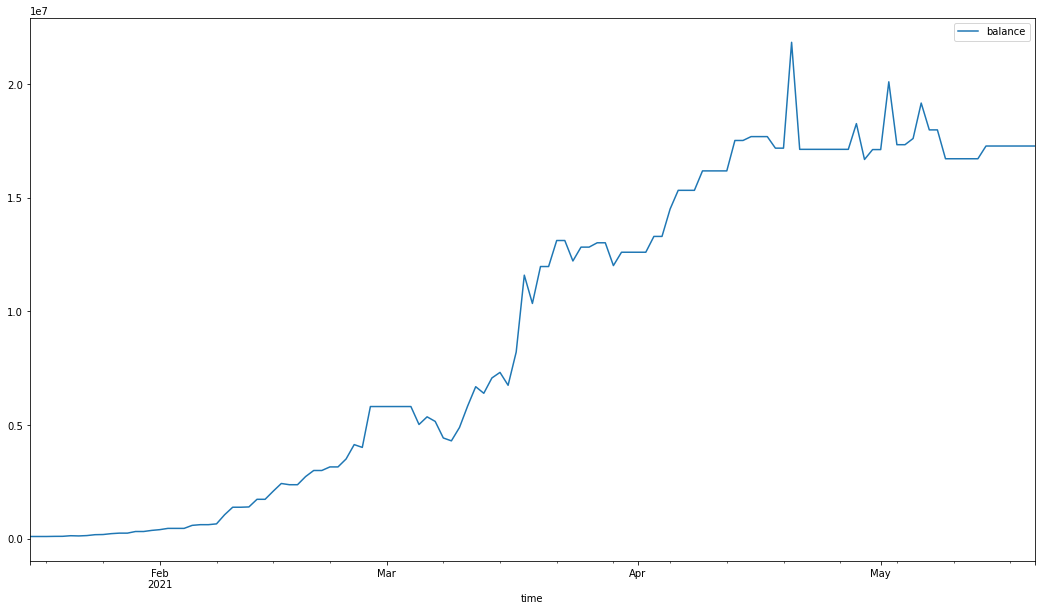

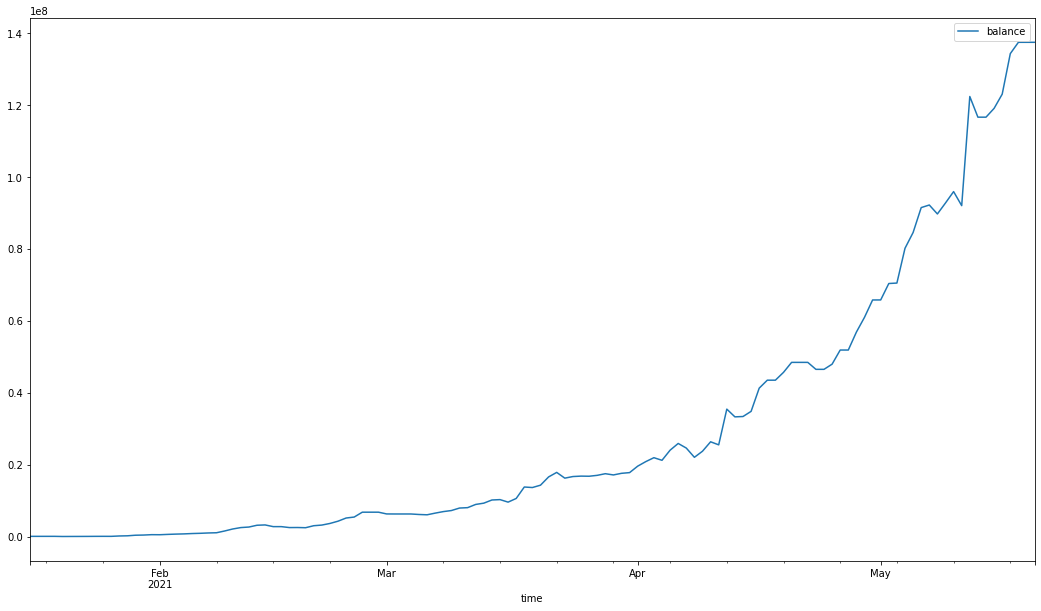

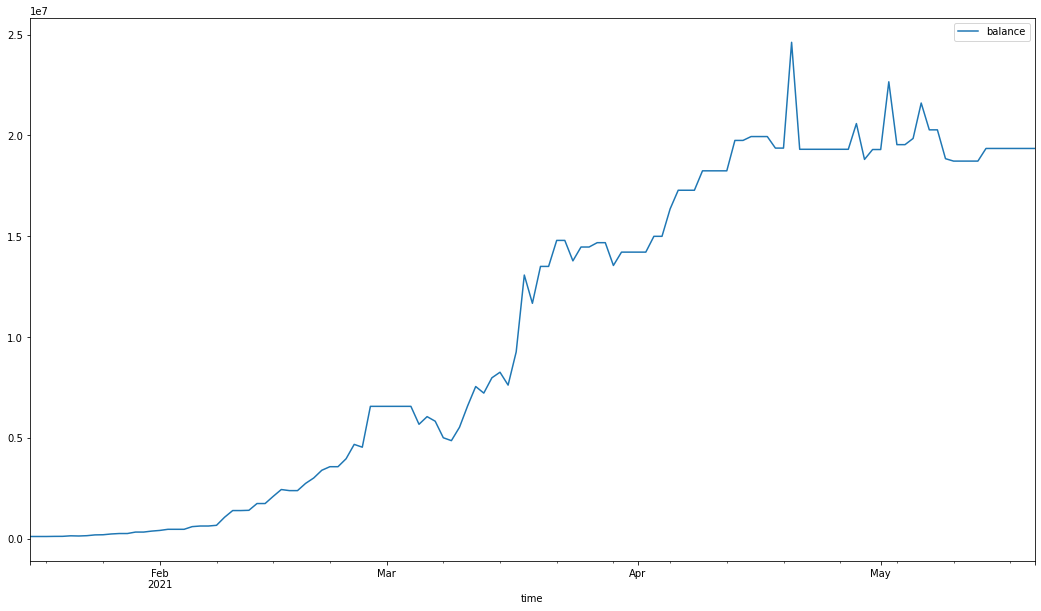

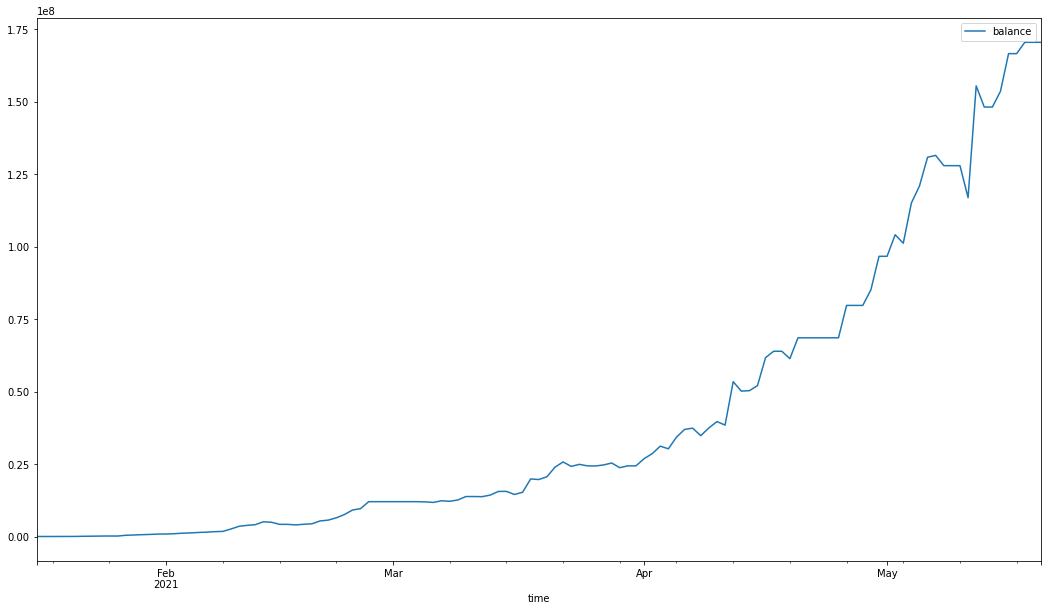

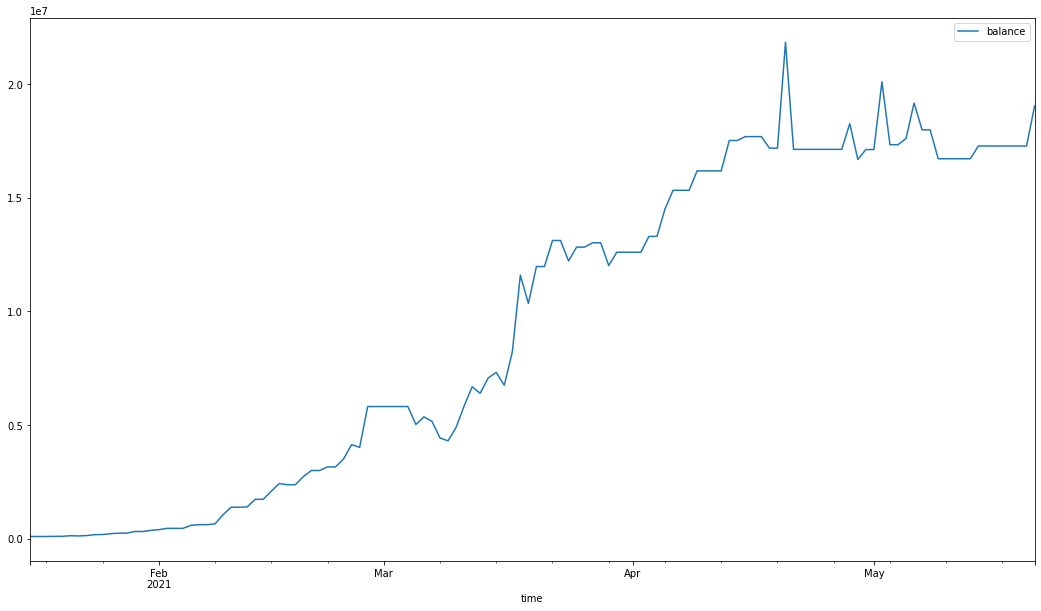

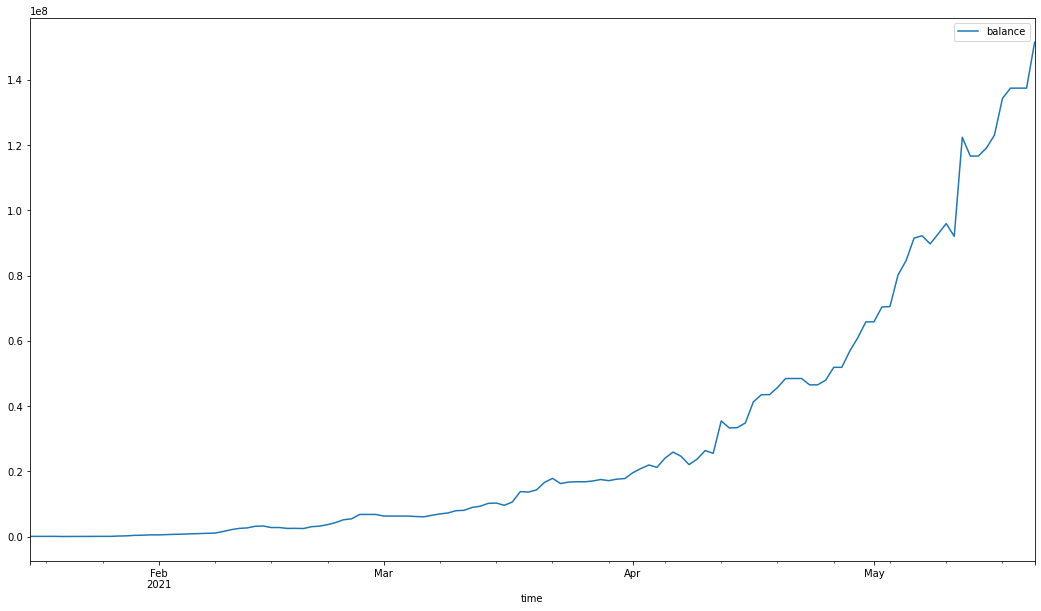

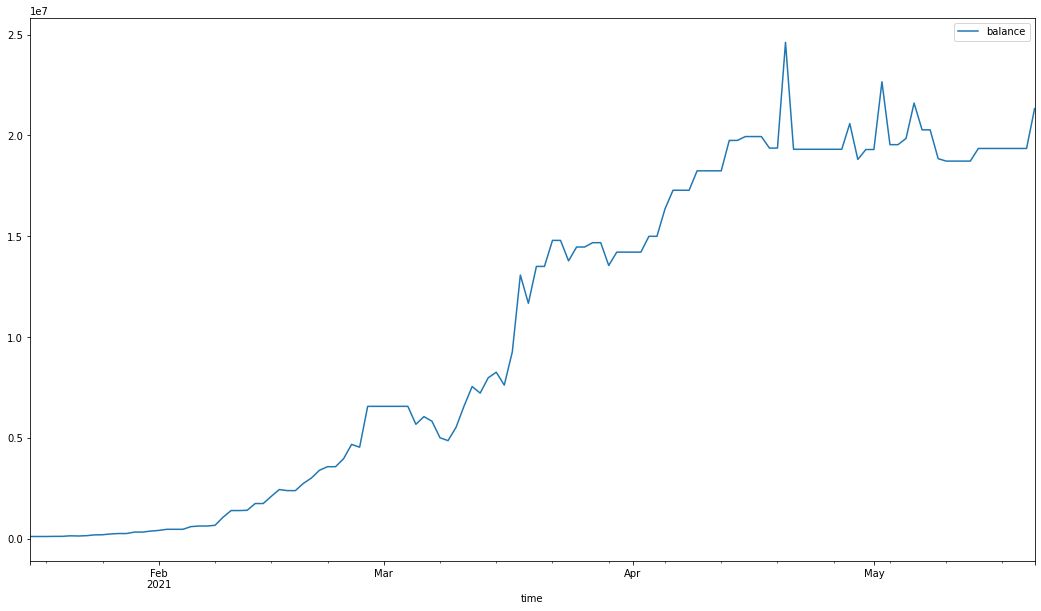

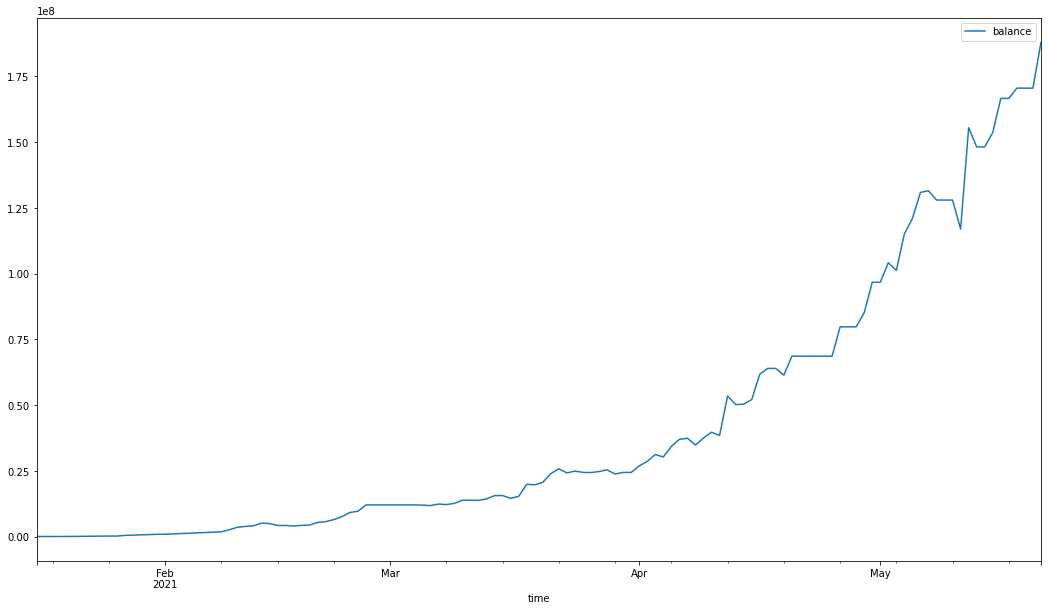

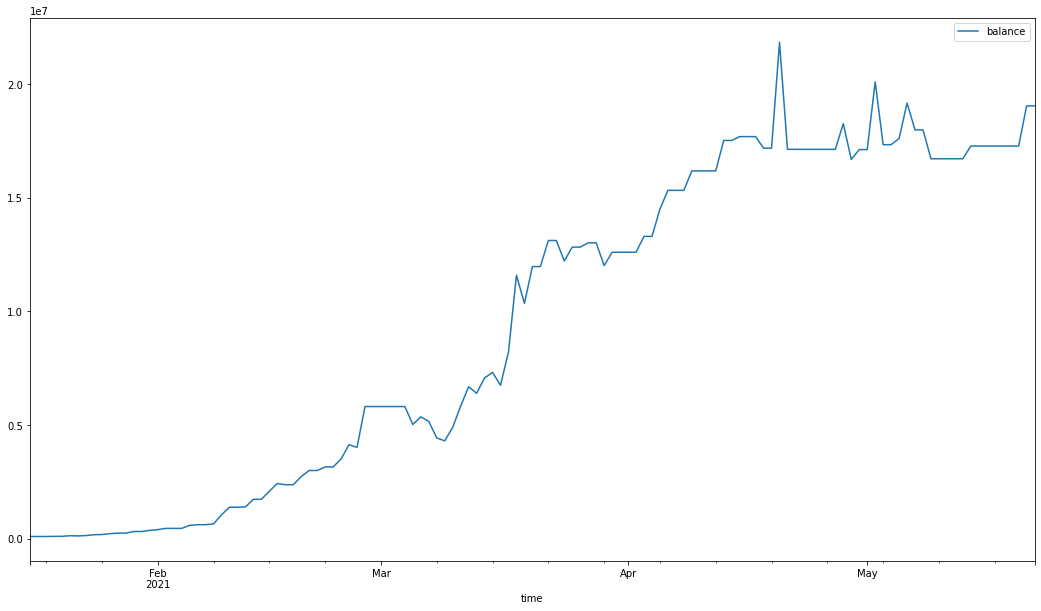

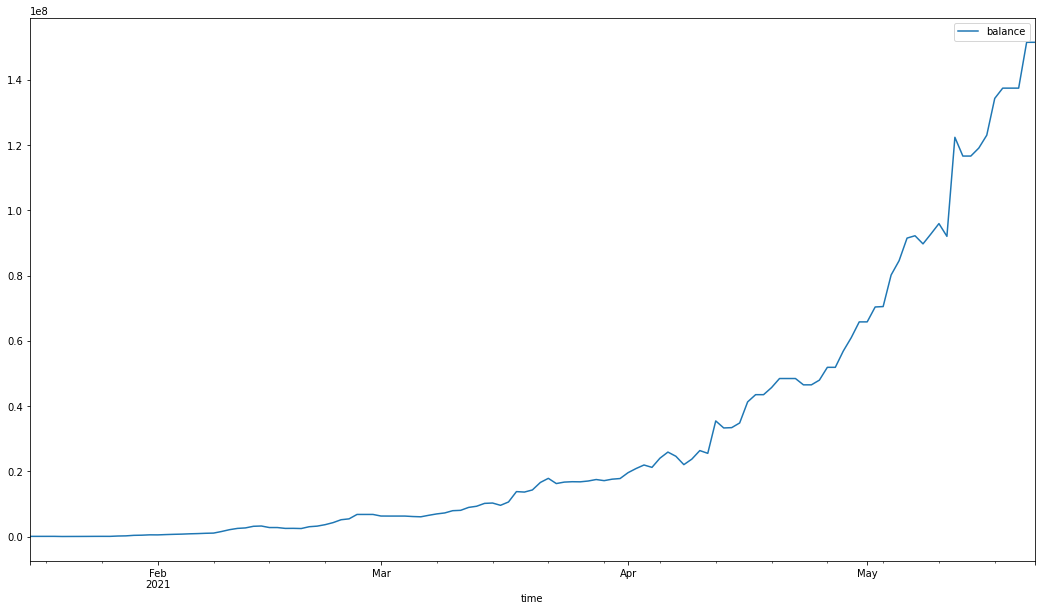

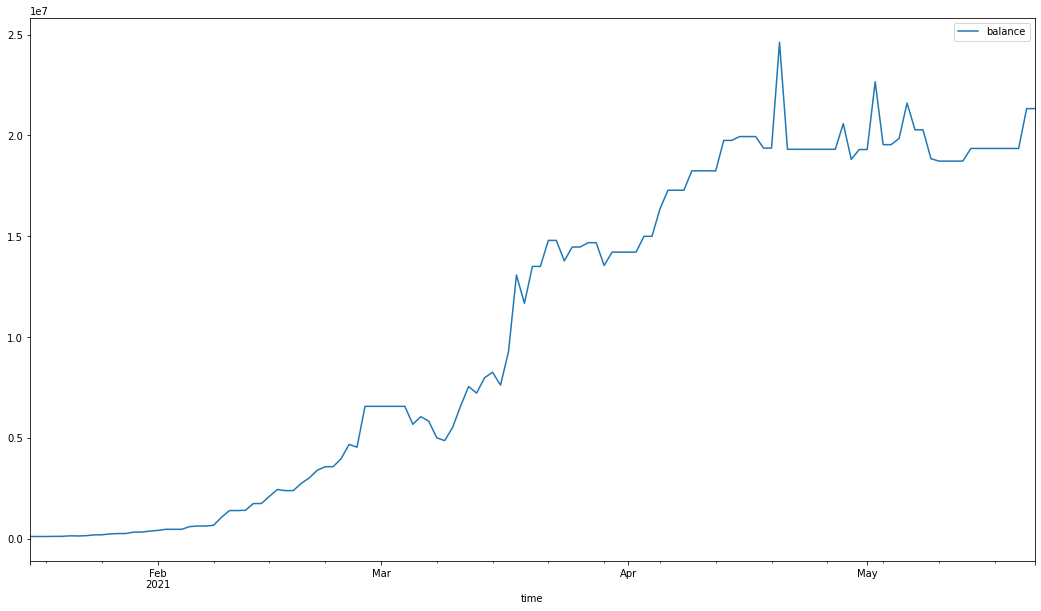

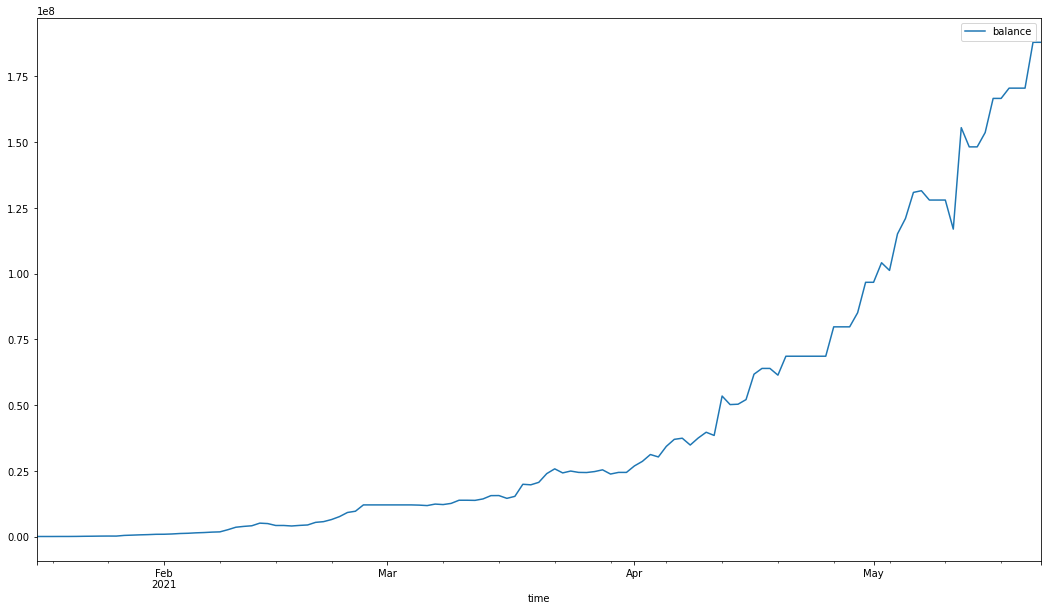

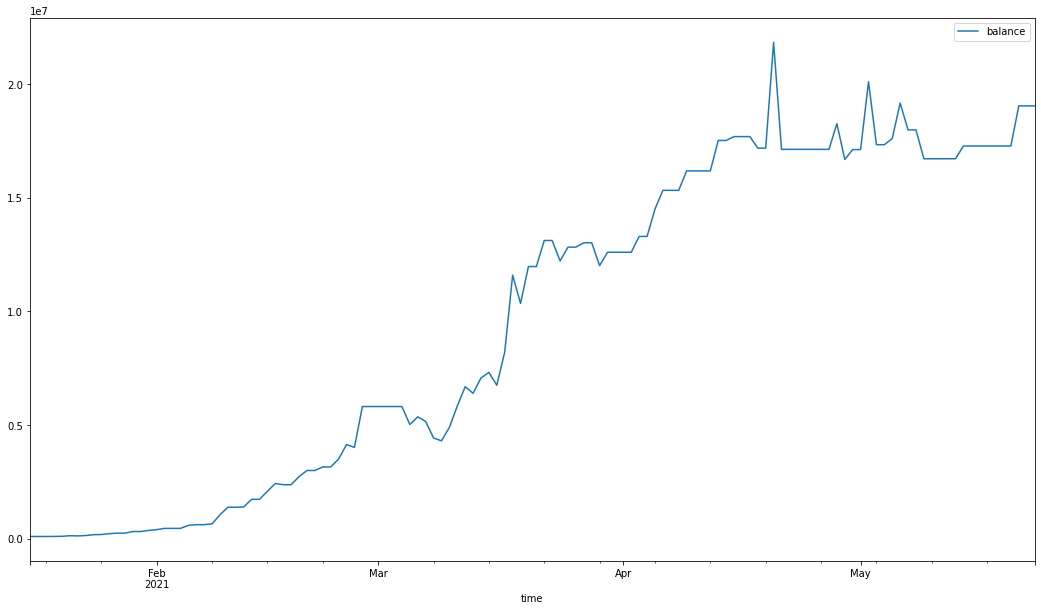

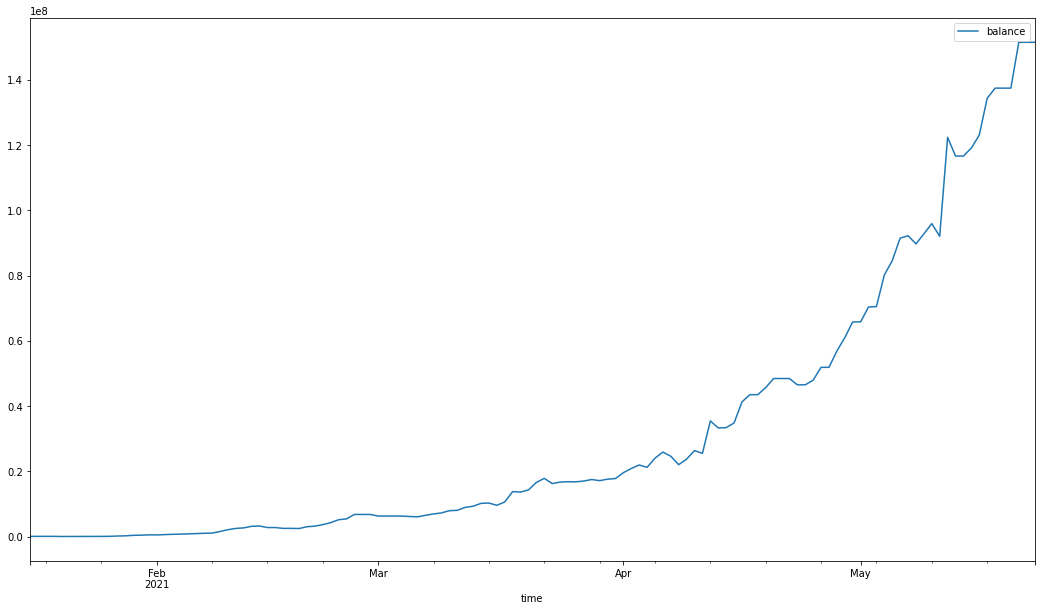

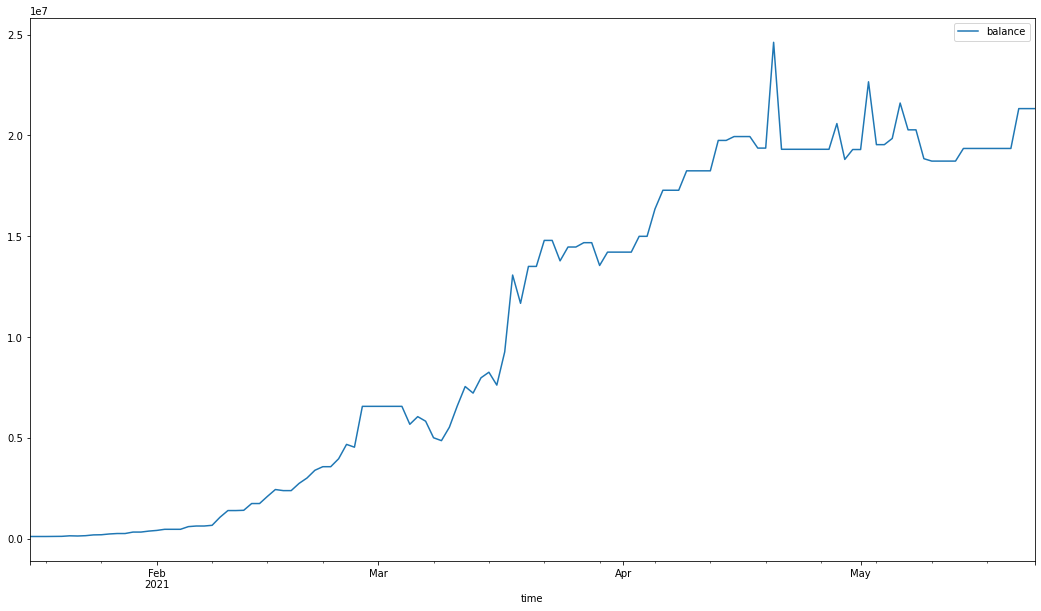

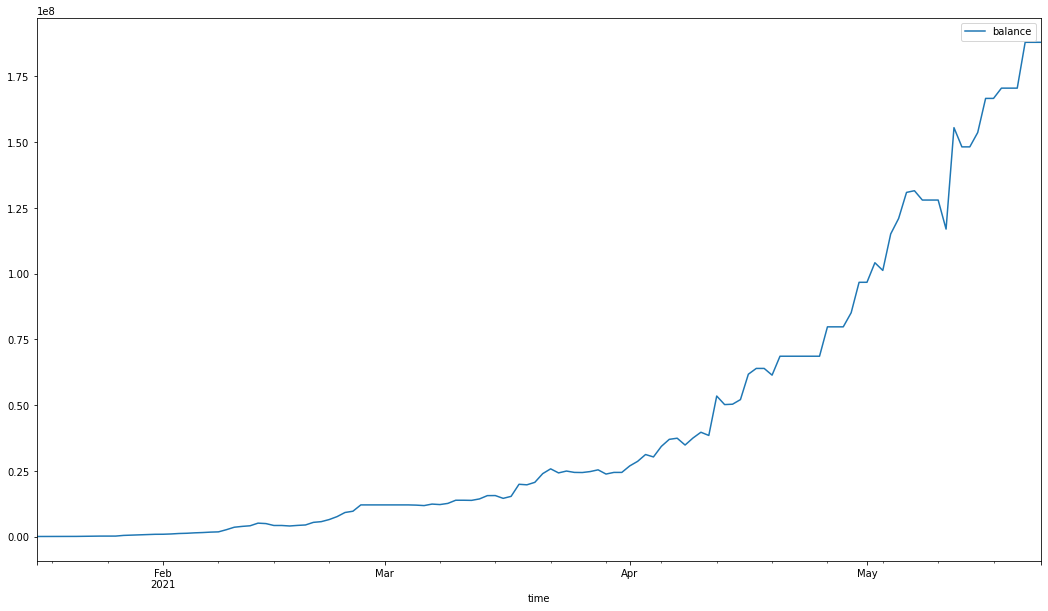

In [42]:
df = merge_neg_div_score(df)

In [43]:
df.columns.tolist()

['date',
 'Symbol',
 'Name',
 'Price',
 'Marketcap CMC',
 'Volume CMC',
 'Circulating supply CMC',
 'MAX Supply CMC',
 'Total Supply CMC',
 'Users 24hr Debank',
 'Transactions Count Debank',
 'Trading Volume Debank',
 'Borrowing Volume Debank',
 'TVL Debank',
 'TVL Defipulse',
 'Users life-to-date duneanlytics',
 'Transaction Revenue',
 'Interest Revenue',
 'Transaction Revenue Supply Side',
 'Interest Revenue Supply Side',
 'Transaction Revenue Protocol',
 'Interest Revenue Protocol',
 'Price/Sale',
 'Transaction GMV',
 'Interest GMV',
 'tvl_defistation',
 'users_defistation',
 'tvl_solana',
 'TVL_max',
 'GMV',
 'Defi Volume DeBank',
 'Defi Volume_max',
 'fully_diluted_mkt_cap',
 'total_revenue',
 'total_supply_revenue',
 'total_protocol_revenue',
 'users_life_max',
 'total_revenue_7d',
 'total_revenue_30d',
 'total_defi_volume_30d',
 'total_users_30d',
 'Defi_volume_pct_chg_1d',
 'Defi_volume_pct_chg_3d',
 'Defi_volume_pct_chg_7d',
 'Defi_volume_pct_chg_30d',
 'MC : VOL',
 'MC_VOL_pc

In [44]:
df

,date,Symbol,Name,Price,Marketcap CMC,Volume CMC,Circulating supply CMC,MAX Supply CMC,Total Supply CMC,Users 24hr Debank,...,sidechain,solana-ecosystem,stablecoin,stablecoin-algorithmically-stabilized,staking,tron,yield-aggregator,yield-farming,3_Day_LB,5_Day_LB
0,2020-12-21,ADA,Cardano,0.152656,4.749512e+09,1.139902e+09,3.111248e+10,4.500000e+10,4.500000e+10,NaN,...,,,,,1,,,,NaN,NaN
1,2020-12-21,IDEX,IDEX,0.034866,1.929840e+07,3.241482e+05,5.535047e+08,NaN,1.000000e+09,NaN,...,,,,,,,,,NaN,NaN
2,2020-12-21,SFI,saffron.finance,358.117719,2.494576e+07,2.255665e+06,6.965800e+04,NaN,7.453361e+04,NaN,...,,,,,,,1,1,NaN,NaN
3,2020-12-21,LINK,Chainlink,12.341995,4.906061e+09,1.245762e+09,3.975096e+08,NaN,1.000000e+09,NaN,...,,1,,,,,,,NaN,NaN
4,2020-12-21,RARI,Rarible,2.605508,2.228570e+06,1.227740e+06,8.553304e+05,NaN,2.500000e+07,NaN,...,,,,,,,,,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17608,2021-05-24,RAY,Raydium,3.890000,1.912226e+08,9.610735e+07,4.927569e+07,5.550000e+08,5.550000e+08,NaN,...,,1,,,,,,,NaN,NaN
17609,2021-05-24,PEAK,PEAKDEFI,0.357735,6.849837e+07,6.239450e+05,1.875341e+08,NaN,5.565385e+08,NaN,...,,,,,,,,,NaN,NaN
17610,2021-05-24,ORN,Orion Protocol,7.380000,1.882102e+08,1.271874e+07,2.543900e+07,1.000000e+08,1.000000e+08,NaN,...,,,,,,,,,NaN,NaN
17611,2021-05-24,PRQ,PARSIQ,0.618266,6.517003e+07,1.743109e+06,1.045861e+08,5.000000e+08,5.000000e+08,NaN,...,,,,,,,,,NaN,NaN


## Farms And Pool

### Append the most stable and non stable farm and pool rates.

In [45]:
stable_coins = "USDT, USDC, DAI, BUSD, SUSD, UST, TUSD".split(",")


def get_stable_coin(pair1, pair2):
    if pair1 in stable_coins:
        return pair1
    elif pair2 in stable_coins:
        return pair2
    else:
        return'NA'


def get_pancakswap_and_raydium_farm_data():
    pancakswap_farm_df = pd.read_sql_query('select * from pancakswap_farm_pool_data;', __connect__())
    pancakswap_farm_df = pancakswap_farm_df[['timestamp_dt', 'pair1', 'pair2', 'pool_rate', 'farm_payment', 'where', 'includes_stablecoin']]
    raydium_farm_df = pd.read_sql_query('select * from raydium_farm_pool_data;', __connect__())
    merged_df = pancakswap_farm_df.append(raydium_farm_df)
    return merged_df


def get_cmc_and_liqudityfolio_pool_and_farm_data_df():
    cmc_farm_df = pd.read_sql_query('select * from cmc_farming_yield;', __connect__())
    cmc_farm_df = cmc_farm_df[['timestamp_dt', 'pair1', 'pair2', 'pool_rate', 'farm_payment', 'where', 'includes_stablecoin']]
    cmc_farm_df = cmc_farm_df[cmc_farm_df['where'].isin(['PancakeSwap', 'SushiSwap', 'BakeryToken', 'SUN'])]
    liquidityfolio_pool_df = pd.read_sql_query('select * from liquidityfolio_pool;', __connect__())
    liquidityfolio_pool_df = liquidityfolio_pool_df[liquidityfolio_pool_df['where'] == 'Uniswap']
    liquidityfolio_pool_df = liquidityfolio_pool_df[['timestamp_dt', 'pair1', 'pair2', 'pool_rate', 'farm_payment', 'where', 'includes_stablecoin']]
    liquidityfolio_pool_df['pool_rate'] = liquidityfolio_pool_df['pool_rate'] * 1200
    merged_df = cmc_farm_df.append(liquidityfolio_pool_df)
    return merged_df


def get_farm_and_pool_merged_data_df():
    cmc_and_liqudityfolio_pool_and_farm_data_df = get_cmc_and_liqudityfolio_pool_and_farm_data_df()
    pancakswap_and_raydium_farm_df = get_pancakswap_and_raydium_farm_data()
    merged_df = cmc_and_liqudityfolio_pool_and_farm_data_df.append(pancakswap_and_raydium_farm_df)
    merged_df['pool_rate'] = merged_df['pool_rate']/100
    return merged_df
    

def get_pool_rates(merged_eth_df, stable, defi_symbol):
    data = [np.nan] * 4
    merged_eth_df = merged_eth_df[(merged_eth_df['includes_stablecoin'] == stable) & (merged_eth_df['farm_payment'].isnull())]
    if not merged_eth_df.empty:
        scenario_1 = merged_eth_df.sort_values(['pool_rate']).iloc[-1]
#         print([defi_symbol, merged_eth_df.shape])
        stable_coin = get_stable_coin(scenario_1['pair1'], scenario_1['pair2'])
        other_pair = scenario_1['pair2'] if scenario_1['pair1'] == defi_symbol else scenario_1['pair1']
        data = [other_pair, scenario_1['pool_rate'], stable_coin, scenario_1['where']]
    return data


def get_farm_rates(merged_eth_df, stable, defi_symbol):
    data = [np.nan] * 5
    merged_eth_df = merged_eth_df[(merged_eth_df['includes_stablecoin'] == stable) & (merged_eth_df['farm_payment'].notnull())]
    if not merged_eth_df.empty:
        scenario_1 = merged_eth_df.sort_values(['pool_rate']).iloc[-1]
        stable_coin = get_stable_coin(scenario_1['pair1'], scenario_1['pair2'])
        other_pair = scenario_1['pair2'] if scenario_1['pair1'] == defi_symbol else scenario_1['pair1']
        data = [other_pair, scenario_1['pool_rate'], stable_coin, scenario_1['where'], scenario_1['farm_payment']]
    return data


def get_farm_and_pool_rates(merged_df):
    data = [np.nan] * 18
    defi_symbol = merged_df['defi_symbol'].max()
    merged_eth_df = merged_df[(merged_df['pair1'] == defi_symbol) | (merged_df['pair2'] == defi_symbol)].copy().reset_index(drop=True)
    if not merged_eth_df.empty:
        scenario_1_data = get_pool_rates(merged_eth_df, True, defi_symbol)
        scenario_2_data = get_pool_rates(merged_eth_df, False, defi_symbol)
        scenario_3_data = get_farm_rates(merged_eth_df, True, defi_symbol)
        scenario_4_data = get_farm_rates(merged_eth_df, False, defi_symbol)
        data = []
        data.extend(scenario_1_data)
        data.extend(scenario_2_data)
        data.extend(scenario_3_data)
        data.extend(scenario_4_data)
    r_data = [defi_symbol]
    r_data.extend(data)
    return r_data


def get_stable_non_stable_pool_rates(merged_eth_df):
    grouped_df = merged_eth_df.sort_values('pool_rate').reset_index(drop=True).groupby('timestamp_dt')
    nd_list = grouped_df.apply(lambda x: get_farm_and_pool_rates(x))
    if len(nd_list) > 0:
        index = nd_list.index[0]
        data = [index]
        data.extend(nd_list[0])
        return data
    return None


def get_farm_and_pool_data_symbols(merged_df, defi_symbols):
    data = []
    for defi_symbol in defi_symbols:
        merged_eth_df = merged_df[(merged_df['pair1'] == defi_symbol) | (merged_df['pair2'] == defi_symbol)].copy().reset_index(drop=True)
        merged_eth_df['defi_symbol'] = defi_symbol
        tmp = get_stable_non_stable_pool_rates(merged_eth_df)
        if tmp:
            data.append(tmp)
    return data


def merge_farm_and_pool_data(data_df):
    defi_symbols = data_df['Symbol'].unique().tolist()
    merged_df = get_farm_and_pool_merged_data_df()
    farm_and_pool_data = get_farm_and_pool_data_symbols(merged_df, defi_symbols)
    columns = ['date', 'symbol', 'top_stable_pool_pair', 'top_stable_pool_rate', 'top_stable_pool_coin', 'top_stable_pool_where', 'top_nonstable_pool_pair', 'top_nonstable_pool_rate', 'top_nonstable_pool_coin', 'top_nonstable_pool_where', 'top_stable_farm_pair', 'top_stable_farm_rate', 'top_stable_farm_coin', 'top_stable_farm_where', 'top_stable_farm_reward', 'top_nonstable_farm_pair', 'top_nonstable_farm_rate', 'top_nonstable_farm_coin', 'top_nonstable_farm_where', 'top_nonstable_farm_reward']
    farm_and_pool_df = pd.DataFrame(farm_and_pool_data, columns=columns)
    tmp_df_4 = pd.merge(data_df, farm_and_pool_df, how='left', left_on=['date', 'Symbol'], right_on=['date', 'symbol'])
    del tmp_df_4['symbol']
    tmp_df_5 = tmp_df_4.set_index(tmp_df_4['date'])
    columns = ['top_stable_pool_pair', 'top_stable_pool_rate', 'top_stable_pool_coin', 'top_stable_pool_where', 'top_nonstable_pool_pair', 'top_nonstable_pool_rate', 'top_nonstable_pool_coin', 'top_nonstable_pool_where', 'top_stable_farm_pair', 'top_stable_farm_rate', 'top_stable_farm_coin', 'top_stable_farm_where', 'top_stable_farm_reward', 'top_nonstable_farm_pair', 'top_nonstable_farm_rate', 'top_nonstable_farm_coin', 'top_nonstable_farm_where', 'top_nonstable_farm_reward']
    for column in columns:
        tmp_df_5[column] = tmp_df_5.groupby('Symbol')[column].transform(lambda x: x.ffill())
    tmp_df_5.reset_index(drop=True)
    return tmp_df_5


In [46]:
merged_df_ = get_farm_and_pool_merged_data_df()
merged_df_[merged_df_['where'] == 'balancer']

,timestamp_dt,pair1,pair2,pool_rate,farm_payment,where,includes_stablecoin


In [47]:
df = merge_farm_and_pool_data(df)
df[df['date'] == pd.to_datetime("4/29/2021")]

,date,Symbol,Name,Price,Marketcap CMC,Volume CMC,Circulating supply CMC,MAX Supply CMC,Total Supply CMC,Users 24hr Debank,...,top_stable_farm_pair,top_stable_farm_rate,top_stable_farm_coin,top_stable_farm_where,top_stable_farm_reward,top_nonstable_farm_pair,top_nonstable_farm_rate,top_nonstable_farm_coin,top_nonstable_farm_where,top_nonstable_farm_reward
date,,,,,,,,,,,,,,,,,,,,,
2021-04-29,2021-04-29,MLN,Enzyme,112.071920,2.009155e+08,4.965963e+06,1.792738e+06,NaN,1.824437e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-29,2021-04-29,RAY,Raydium,13.112521,4.867590e+08,4.524945e+07,3.712170e+07,5.550000e+08,5.550000e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-29,2021-04-29,XVS,Venus,116.776768,1.130420e+09,5.298495e+08,9.680181e+06,3.000000e+07,3.000000e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-29,2021-04-29,EGG,Goose Finance,13.003595,2.282300e+07,4.189724e+06,1.755130e+06,NaN,1.867616e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-29,2021-04-29,FARM,Harvest Finance,192.996209,1.035068e+08,1.976244e+06,5.363154e+05,6.904200e+05,5.636245e+05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-29,2021-04-29,SOL,Solana,42.460540,1.147058e+10,7.722593e+08,2.701469e+08,NaN,4.943087e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-29,2021-04-29,DCR,Decred,207.948708,2.677308e+09,2.432330e+07,1.287485e+07,2.100000e+07,1.287485e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-29,2021-04-29,MEME,Meme,1444.831152,4.045527e+07,5.364973e+06,2.800000e+04,2.800000e+04,2.800000e+04,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
df[df['date'] == pd.to_datetime("5/1/2021")]['top_nonstable_farm_pair'].unique()

array(['WBNB', nan, 'ETH', 'YFII', 'BNB', 'WIN'], dtype=object)

In [49]:
df.columns.tolist()

['date',
 'Symbol',
 'Name',
 'Price',
 'Marketcap CMC',
 'Volume CMC',
 'Circulating supply CMC',
 'MAX Supply CMC',
 'Total Supply CMC',
 'Users 24hr Debank',
 'Transactions Count Debank',
 'Trading Volume Debank',
 'Borrowing Volume Debank',
 'TVL Debank',
 'TVL Defipulse',
 'Users life-to-date duneanlytics',
 'Transaction Revenue',
 'Interest Revenue',
 'Transaction Revenue Supply Side',
 'Interest Revenue Supply Side',
 'Transaction Revenue Protocol',
 'Interest Revenue Protocol',
 'Price/Sale',
 'Transaction GMV',
 'Interest GMV',
 'tvl_defistation',
 'users_defistation',
 'tvl_solana',
 'TVL_max',
 'GMV',
 'Defi Volume DeBank',
 'Defi Volume_max',
 'fully_diluted_mkt_cap',
 'total_revenue',
 'total_supply_revenue',
 'total_protocol_revenue',
 'users_life_max',
 'total_revenue_7d',
 'total_revenue_30d',
 'total_defi_volume_30d',
 'total_users_30d',
 'Defi_volume_pct_chg_1d',
 'Defi_volume_pct_chg_3d',
 'Defi_volume_pct_chg_7d',
 'Defi_volume_pct_chg_30d',
 'MC : VOL',
 'MC_VOL_pc

## Saving to csv File

In [50]:
df.shape

(17613, 216)

In [51]:
df.to_csv('master_data_ratios_and_percentages.csv', index = False)

In [52]:
df.date.max()

Timestamp('2021-05-24 00:00:00')

In [53]:
df[df['Symbol'] == 'AAVE'][['Users life-to-date duneanlytics','date']]

,Users life-to-date duneanlytics,date
date,,
2020-12-21,32549.0,2020-12-21
2020-12-22,32624.0,2020-12-22
2020-12-23,32697.0,2020-12-23
2020-12-24,32781.0,2020-12-24
2020-12-25,32907.0,2020-12-25
...,...,...
2021-05-20,52414.0,2021-05-20
2021-05-21,52414.0,2021-05-21
2021-05-22,52414.0,2021-05-22


In [54]:
df

,date,Symbol,Name,Price,Marketcap CMC,Volume CMC,Circulating supply CMC,MAX Supply CMC,Total Supply CMC,Users 24hr Debank,...,top_stable_farm_pair,top_stable_farm_rate,top_stable_farm_coin,top_stable_farm_where,top_stable_farm_reward,top_nonstable_farm_pair,top_nonstable_farm_rate,top_nonstable_farm_coin,top_nonstable_farm_where,top_nonstable_farm_reward
date,,,,,,,,,,,,,,,,,,,,,
2020-12-21,2020-12-21,ADA,Cardano,0.152656,4.749512e+09,1.139902e+09,3.111248e+10,4.500000e+10,4.500000e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-21,2020-12-21,IDEX,IDEX,0.034866,1.929840e+07,3.241482e+05,5.535047e+08,NaN,1.000000e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-21,2020-12-21,SFI,saffron.finance,358.117719,2.494576e+07,2.255665e+06,6.965800e+04,NaN,7.453361e+04,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-21,2020-12-21,LINK,Chainlink,12.341995,4.906061e+09,1.245762e+09,3.975096e+08,NaN,1.000000e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-21,2020-12-21,RARI,Rarible,2.605508,2.228570e+06,1.227740e+06,8.553304e+05,NaN,2.500000e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,2021-05-24,RAY,Raydium,3.890000,1.912226e+08,9.610735e+07,4.927569e+07,5.550000e+08,5.550000e+08,NaN,...,USDT,1.9037,USDT,Raydium,RAY,KIN,1.8563,NA,Raydium,KIN-RAY
2021-05-24,2021-05-24,PEAK,PEAKDEFI,0.357735,6.849837e+07,6.239450e+05,1.875341e+08,NaN,5.565385e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-24,2021-05-24,ORN,Orion Protocol,7.380000,1.882102e+08,1.271874e+07,2.543900e+07,1.000000e+08,1.000000e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
df = df.sort_values(['Symbol', 'Name'])

(df['Symbol'] + "____" + df['Name']).unique().tolist()

['1INCH____1inch',
 'AAVE____Aave',
 'AC____ACoconut',
 'ACS____ACryptoS',
 'ADA____Cardano',
 'ALCX____Alchemix',
 'ALEPH____Aleph.im',
 'ALPA____Alpaca City',
 'ALPACA____Alpaca Finance',
 'ANY____Anyswap',
 'ARMOR____ARMOR',
 'AST____AirSwap',
 'AUC____Auctus',
 'AUDIO____Audius',
 'AUTO____Auto',
 'BAC____Basis Cash',
 'BADGER____Badger DAO',
 'BAL____Balancer',
 'BANANA____ApeSwap Finance',
 'BANK____Float Protocol',
 'BASE____Base Protocol',
 'BDP____Big Data Protocol',
 'BIFI____Beefy.Finance',
 'BIFI____BiFi',
 'BNB____Binance Coin',
 'BOND____BarnBridge',
 'BOR____BoringDAO',
 'BTC____Bitcoin',
 'BUNNY____Pancake Bunny',
 'BZRX____bZx Protocol',
 'CAKE____PancakeSwap',
 'COFI____CoFiX',
 'COMP____Compound',
 'CORE____cVault.finance',
 'CRV____Curve DAO Token',
 'CRX____CryptEx',
 'DCR____Decred',
 'DDX____DerivaDAO',
 'DEGO____Dego Finance',
 'DFD____DefiDollar DAO',
 'DMG____DMM: Governance',
 'DODO____DODO',
 'DOGE____Dogecoin',
 'DOT____Polkadot',
 'DOUGH____PieDAO DOUGH v2

In [56]:
df.Symbol.unique()

array(['1INCH', 'AAVE', 'AC', 'ACS', 'ADA', 'ALCX', 'ALEPH', 'ALPA',
       'ALPACA', 'ANY', 'ARMOR', 'AST', 'AUC', 'AUDIO', 'AUTO', 'BAC',
       'BADGER', 'BAL', 'BANANA', 'BANK', 'BASE', 'BDP', 'BIFI', 'BNB',
       'BOND', 'BOR', 'BTC', 'BUNNY', 'BZRX', 'CAKE', 'COFI', 'COMP',
       'CORE', 'CRV', 'CRX', 'DCR', 'DDX', 'DEGO', 'DFD', 'DMG', 'DODO',
       'DOGE', 'DOT', 'DOUGH', 'DRC', 'DSD', 'EGG', 'EPS', 'ESD', 'ETH',
       'FARM', 'FIDA', 'FIL', 'FIN', 'FLX', 'FNX', 'FOR', 'FRAX', 'FRM',
       'FRONT', 'FST', 'FUEL', 'GNO', 'GRT', 'HEGIC', 'ICHI', 'IDEX',
       'IMX', 'INDEX', 'INV', 'JULD', 'KEBAB', 'KEEP', 'KIN', 'KP3R',
       'KSM', 'L2', 'LIEN', 'LINA', 'LINK', 'LPT', 'LQTY', 'LRC', 'LTC',
       'LUA', 'LUNA', 'MAPS', 'MARK', 'MATIC', 'MCB', 'MDO', 'MDX',
       'MEME', 'MET', 'MIR', 'MKR', 'MLN', 'MM', 'MPH', 'NDX', 'NRV',
       'NUTS', 'NXS', 'ONC', 'ONES', 'ONX', 'OPIUM', 'ORAI', 'ORN', 'OXY',
       'PEAK', 'PERP', 'PICKLE', 'PIPT', 'POOL', 'POWER', 'PRQ', 'RAI',
 